# HRS Cognition And Employment Data Expoloration

The aim of this year's Inter-Unversity Health Data Inquiry Program, Ageing Powerfully, is to gain deeper insights in the chronic disease progress and develop a tailored intervention that optimize patient outcome. We will focus on cognitive decline. Our research question is:

How can we help senior adults choose their post-retirement careers that are protective to their cognitive abilities while align with their former work experience, skills, and interests?

Our research goal is:  
Use HRS occupation pattern and cognition data to design a low-burden and high impact post-retirement plan that slows cognitive decline in seniors.

Our target population is: all elderlies at age 65+.  

Our study population is: all elderlies at age 65+ in the U.S.

Our sample is: elderlies at age 65+ interviewed by HRS longitudinal study between 1992 and 2022.

In [1]:
## Scientific Computing with Python
import pandas as pd
import numpy as np

## Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import statsmodels.api as sm

## File dirtectory
import os

# 1. Import Data

In [4]:
## Modifiable data path
workingDir = os.getcwd()
hrsFullPath = os.path.join(workingDir,'..', 'Data', 'randhrs1992_2022v1.sas7bdat')

## Due to big file size, only select the first 10000 rows as the sample for EDA
hrsFull = pd.read_sas(hrsFullPath, chunksize=10000)

## Get only thef first chunk of the data for EDA
hrsFull = next(hrsFull)
print(hrsFull.shape)


(10000, 19880)


# 2. Preparing Variables of Interest

## 2.1 Unpivot Table to Long Format

Each row of the original data represents all records collected from the same person (wide format), we need convert this to a long format to inspect the temporal change in the same target person.

In [144]:
## Specifiy variable categories
idx = ["HHIDPN"]
cogniScore = [
    "RwSTATUS", ## 1=cognitive measure is provided, 2=interview by proxy, w=not responded
    "RwIMRC", ## Immediate word recall score
    "RwDLRC", # delayed word recall
    "RwSER7", # serial 7s score
    "RwVOCAB", # vocabulary score, categorical, correct, incorrect, or partially correct
    "RwBWC86", # counting backwards from 86
    "RwBWC20", # counting backwards from 20
    "RwTR20", ## recall index summary
    "RwMSTOT", # mental status index summary
    "RwLOST", # cognitive impairment: getting lost
    "RwWANDER", # cognitive impairment: wandering off
    "RwALONE", # cognitive impairment: left alone
    "RwHALUC", # cognitive impairment: getting lost
]

demographics = ["RAGENDER", # Reference person gender
                "RARACEM", # Reference person race
                "RwCENREG", # Reference person census region
                "RAEDYRS", # Reference person education years
                "RwMSTAT", # Reference person marital status
                "RwAGEM_B", #W1 R Age (months) at Ivw BegMonth
                "RwLIVBRO", # Reference person number of siblings
                "RAEVBRN"] # Reference person number of children ever born]

employmentVars = [
    "RwWORK", # W1 R working for pay
    "RwJHOURS", # W1 Hours worked/week main job
    "RwWGIHR", # W1 Imputed Wage Rate-Hrly
    "RwJCIND", # Industru code for the current job
    "RwJCOCC", # W1 Current Job Occup/1980 Census
    "RwJPHYS", # W1 Cur job req lots phys effort Categ
    "RwJLIFT", # W1 Cur job req lift heavy loads
    "RwJSTRES", # W1 Cur job involves much stress
    "RwJSTOOP", # W1 Cur job req stoop/kneel/crouch
    "RwJSIGHT", # W1 Cur job req good eyesight
]

interestVars = demographics + cogniScore + employmentVars

In [89]:
def unpivotMetric(df, metricName, idCol="HHIDPN"):
    """
    Helper function: unpivot a metric from wide to long format.
    
    Parameters:
    df (DataFrame): The DataFrame containing the metric.
    metricName (str): The name of the metric to unpivot, in regex pattern.
    idCol (str): The identifier column name.
    
    Returns:
    DataFrame: The unpivoted DataFrame.
    """
    metricName = metricName.replace("Rw", "R\\d+")
    idx = df.filter(items = ["HHIDPN"])
    df = df.filter(regex = metricName+"$")
    df = pd.concat([idx, df], axis=1)
    # print(df.columns[1:])

    valueNames = df.columns[df.columns.str.contains(metricName)].to_list()
    metricNewName = metricName.replace("R\\d+", "Rw")
    df = df.melt(id_vars=[idCol], value_vars=valueNames, 
                 var_name="Wave", value_name=metricNewName)
    
    df["Wave"] = df["Wave"].str.extract(r'(\d+)').astype(int)  # Extract the wave number from the column name
    df[idCol] = df[idCol].astype(int)
    df.sort_values(by=[idCol, "Wave"], inplace=True)
    # df[metricNewName].to_csv(fileNameWave, mode='a', header=False, index=False) # append to the end of the file    
    return df

def joinMetrics(df, metrics, fileNameWave, idCol="HHIDPN"):
    """
    Helper function: join multiple metrics in multiple waves into a single DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame containing the metrics.
    metrics (list): List of metric names to join.
    idCol (str): The identifier column name.

    Returns: None 
    Side Effects: 
    Write a joined DataFrame to a CSV file with all metrics for each wave.
    The DataFrame contains the same id column that enables them to be joined.
    """
    unique_ids = df[idCol].astype(int).unique()
    joinedDf = pd.DataFrame({
        "HHIDPN": np.repeat(unique_ids, 16),
        "Wave": np.tile([i for i in range(1, 17)], len(unique_ids))
    })

    # print(joinedDf[["HHIDPN", "Wave"]].dtypes)

    joinedDf.sort_values(by=[idCol, "Wave"], inplace=True)
    joinedDf.to_csv(fileNameWave, index=False)
    
    # joinedDf[idCol] = joinedDf[idCol].astype(int)  

    for metric in metrics:
        unpivoted = unpivotMetric(df, metric)
        # print(unpivoted.info())
        # unpivoted.to_csv(fileNameWave, mode='a', header=False, index=False) # append to the end of the file
        joinedDf = pd.merge(joinedDf, unpivoted, ## linking table
                            on=["HHIDPN", "Wave"], 
                            how="left")
        # joinedDf = pd.concat([joinedDf, unpivoted], axis=1, ignore_index=True)
        joinedDf.to_csv(fileNameWave, index=False) # append to the end of the file
        
    return None


def selectMetricforAll(df, metricNames, fileNameAll, idCol="HHIDPN"):
    """
    Helper function: select variables not specific any single wave as well as the id column
    
    Parameters:
    df (DataFrame): The DataFrame containing the metrics.
    metricsNames (list): List of metric names to join.
    idCol: the identfier column of each individual

    Returns:
    DataFrame: The joined DataFrame with metrics not specific to any single wave
    """
    targetDf = df[metricNames]
    targetDf.dropna(axis = 0, how = "all", inplace = True)
    targetDf = pd.concat([df[[idCol]], targetDf], axis=1)
    targetDf.to_csv(fileNameAll, index=False)
    return None


def unPivotSelectedVars(df, metricNames, fileNameAll, fileNameWave, idCol="HHIDPN"):
    """
    A wrapper function that calls helper functions, converting wide data to long format for selected metrics.
    This function separates metrics that are not specific to any single wave from those that are specific to every wave.
    It returns two data frames: one for metrics not specific to any single wave and another for metrics specific to every wave.
        

    Parameters:
    df (DataFrame): The DataFrame containing the metrics.
    metricNames (list): List of metric names to join, case sensitive.
    fileNameAll: file name for the data frame containing metrics not specific to any single wave
    fileNameWave:file name for the data frame containing metrics specific to any single wave
    idCol: the identfier column of each individual

    Return: None 

    Side Effects:
    Write two data frames: 
    the first data frame contains metrics not specific to any single wave, 
    the second data frame contains metric specific to every wave.
    Each data frame contains the same id column that enables them to be joined
    """
    
    ## Select all columns names that starts with RA
    varAll = [s for s in metricNames if s.startswith("RA")]
    selectMetricforAll(df, varAll, fileNameAll)

    ## Select all columns names that starts with Rw
    # varWaves =  [s for s in metricNames if s.startswith("Rw")]
    # joinMetrics(df, varWaves, fileNameWave)

    return None

In [ ]:
# df1 = unpivotMetric(hrsFull, demographics[5]) 
# df1.info()
# df2 = unpivotMetric(hrsFull, "RwSTATUS")
# df2
# df3 = pd.merge(df1, df2, on=["HHIDPN", "Wave"], how="outer")
# df3.sort_values(by=["HHIDPN", "Wave"], inplace=True)
# df3

# Join all metrics into a single DataFrame
# joinMetrics(hrsFull, employmentVars, 'joinedWave10kRows.csv')
# unPivotSelectedVars(hrsFull, interestVars, 'joinedAll10kRows.csv', 'joinedWaves10kRows.csv')

C:\Users\86139\AppData\Local\Temp\ipykernel_3396\1385755786.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetDf.dropna(axis = 0, how = "all", inplace = True)


## 2.2 Inpect Missingness of Data

In [91]:
del hrsFull
import gc
gc.collect()  # Run garbage collection to free up memory

66

In [74]:
## Read saved data files
hrsByWave = pd.read_csv('joinedWaves10kRows.csv')
hrsInAll = pd.read_csv( 'joinedAll10kRows.csv')

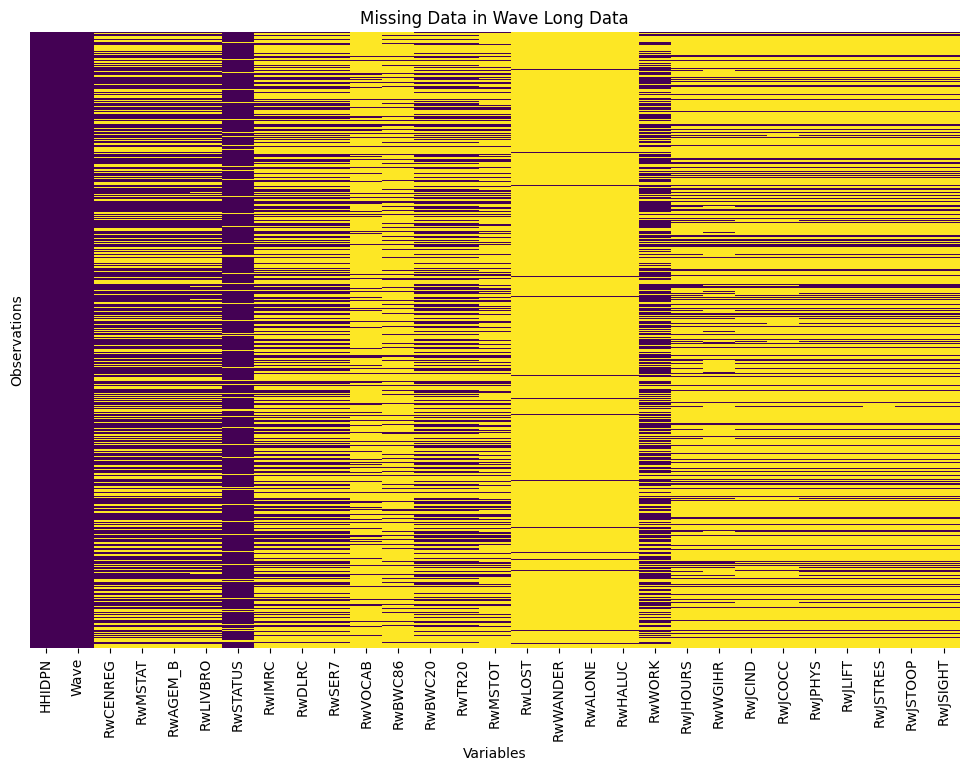

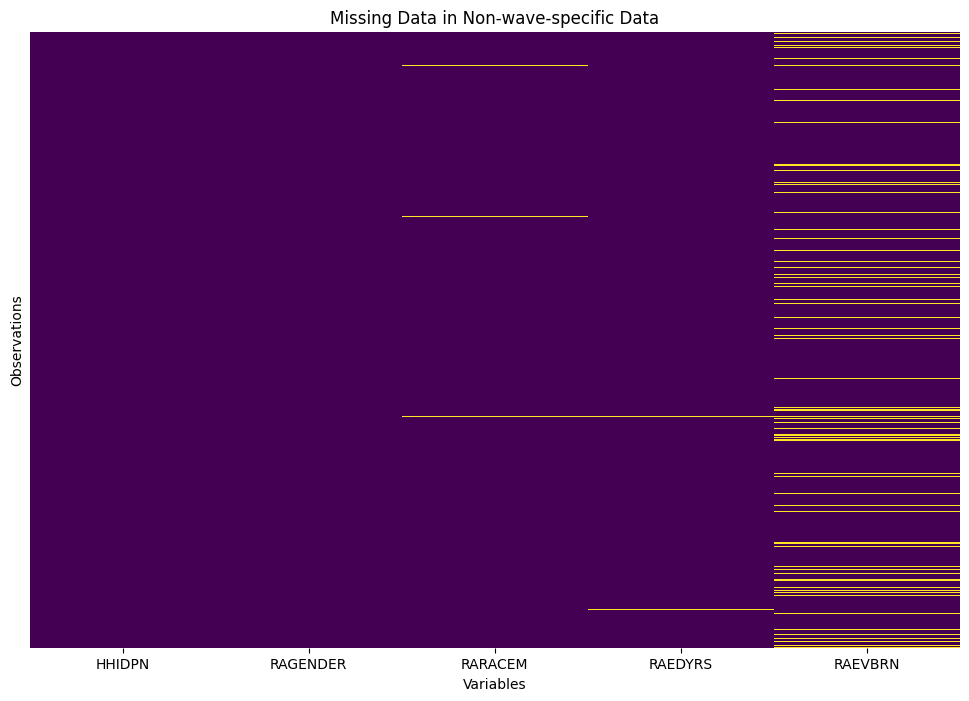

In [ ]:
## Inspect missing data using heatmap
missingByWave = hrsByWave.isnull()
missingInAll = hrsInAll.isnull()

plt.figure(figsize=(12, 8))
sns.heatmap(missingByWave, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data in Wave Long Data')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(missingInAll, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data in Non-wave-specific Data')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.show()


In [94]:
## Most of the portion in following variables are missing, but they are important cognitive impairment measures
## What distinct values do these variables have?
# raggedCols = ["R3LOST", "R3WANDER", "R3ALONE"]

# for col in raggedCols: 
#     print(f"Unique values in {col}: {hrs[col].unique()}")
#     print(f"Value counts in {col}:\n{hrs[col].value_counts()}\n")

# 3. What is the compomentary pattern between cognitive impariment and cognitive scores?

In [40]:
cogniScore = [
    #"RwSTATUS", ## 1=cognitive measure is provided, 2=interview by proxy, w=not responded
    "RwIMRC", ## Immediate word recall score
    "RwDLRC", # delayed word recall
    "RwSER7", # serial 7s score
    "RwVOCAB", # vocabulary score, categorical, correct, incorrect, or partially correct
    "RwBWC86", # counting backwards from 86
    "RwBWC20", # counting backwards from 20
    "RwTR20", ## recall index summary
    "RwMSTOT" # mental status index summary
]

cogniImpr = [
    "RwLOST", # cognitive impairment: getting lost
    "RwWANDER", # cognitive impairment: wandering off
    "RwALONE", # cognitive impairment: left alone
    "RwHALUC", # cognitive impairment: getting lost
]

## For rows where any coogniImpr is not null, are cogniScore also not null?
## Get the row names where any cognitive impairment measure is not null
cogniImprNotNull = hrsByWave[cogniImpr].notnull().any(axis=1)
print(cogniImprNotNull.head())
print(f"The number of non-empty cognitive impairement measures: {cogniImprNotNull.sum()}")

# # # For rows where any cogniScore is not null, are cogniImpr also not null?
cogniScoreNotNull = hrsByWave.loc[cogniImprNotNull, cogniScore].notnull().any(axis=1)
print(cogniScoreNotNull.shape)
print(cogniScoreNotNull.head())
print("The number of non-empty cognitive scores among cognitively impaired group: ", cogniScoreNotNull.sum())

0    False
1    False
2    False
3    False
4    False
dtype: bool
The number of non-empty cognitive impairement measures: 4151
(4151,)
82     False
242    False
243    False
244    False
254    False
dtype: bool
The number of non-empty cognitive scores among cognitively impaired group:  2


**OBservation**:

1. Out of 16000 rows, there are 4151 non-empty impairement measures.
2. Among these  4151 non-empty impairements, 4149 cognitive scores are non-empty, 2 are empty.
3. This validates the hypothesis that no cognitive score is measured among impaired group.

In [43]:
## For rows where any coogniImpr is not null, are cogniScore also not null?
## Get the row names where any cognitive impairment measure is not null
cogniScoreNotNull = hrsByWave[cogniScore].notnull().any(axis=1)
print(cogniScoreNotNull.head())
print(f"The number of non-empty cognitive impairement measures: {cogniScoreNotNull.sum()}")

# # # For rows where any cogniScore is not null, are cogniImpr also not null?
cogniImprNotNull = hrsByWave.loc[cogniScoreNotNull, cogniImpr].notnull().any(axis=1)
print(cogniImprNotNull.shape)
print(cogniImprNotNull.head())
print("The number of non-empty cognitive scores among cognitively impaired group: ", cogniImprNotNull.sum())

0    False
1    False
2    False
3    False
4    False
dtype: bool
The number of non-empty cognitive impairement measures: 64878
(64878,)
18    False
19    False
20    False
34    False
35    False
dtype: bool
The number of non-empty cognitive scores among cognitively impaired group:  2


**OBservation**:

1. Out of 16000 rows, there are 64878 non-empty cognitive scores measures.
2. Among these  64878 non-empty impairements, only 2 are empty.
3. This validates the hypothesis that cognitive score and impairment are chosen one over another.

**Next Step**:
Identify the the two individuals with both scores and impairements measured. They are outliers.

In [44]:
## Extract HHIDPN where both cognitive scores and impairments are not null
cogniImprNotNull = hrsByWave[cogniImpr].notnull().any(axis=1)
cogniScoreNotNull = hrsByWave[cogniScore].notnull().any(axis=1)
bothNotNull = cogniImprNotNull & cogniScoreNotNull
bothNotNullHHIDPN = hrsByWave.loc[bothNotNull, ["HHIDPN", "Wave"]]
print(bothNotNullHHIDPN.shape)
print(bothNotNullHHIDPN.head())

(2, 2)
          HHIDPN  Wave
143251  56051011     4
143267  56051040     4


These outliers are two people in the wave 4.

In [46]:
## Inpect two outliers
print(hrsByWave.loc[bothNotNull, :].T)
print(hrsInAll.loc[bothNotNull, :])


              143251      143267
HHIDPN    56051011.0  56051040.0
Wave             4.0         4.0
RwCENREG         3.0         3.0
RwMSTAT          3.0         2.0
RwAGEM_B       871.0       835.0
RwLIVBRO         1.0         0.0
RwSTATUS         1.0         1.0
RwIMRC           2.0         8.0
RwDLRC           1.0         8.0
RwSER7           1.0         5.0
RwVOCAB          2.0         3.0
RwBWC86          1.0         2.0
RwBWC20          1.0         2.0
RwTR20           3.0        16.0
RwMSTOT          8.0        15.0
RwLOST           0.0         0.0
RwWANDER         0.0         0.0
RwALONE          0.0         1.0
RwHALUC          0.0         0.0
RwWORK           0.0         0.0
RwJHOURS         NaN         NaN
RwWGIHR          NaN         NaN
RwJCIND          NaN         NaN
RwJCOCC          NaN         NaN
RwJPHYS          NaN         NaN
RwJLIFT          NaN         NaN
RwJSTRES         NaN         NaN
RwJSTOOP         NaN         NaN
RwJSIGHT         NaN         NaN
Empty Data

The two outliers seem to have extremely poor cognitive score. Mental status was 8 for 143251, 15 for 143267. 143267 cannot be left alone and need caregiver to to nurse it. Both elderlies are above 69 years old, cognitive damage by aging is likely accumulated to an irreversible level.

0 indicates no, 1 indicates yes. For participants aged less than 65 years, cognitive impairment measurements are skipped.

# 4. What is the unconditional distribution of the outcome variables?

## 4.1 Cognitive Score Distribution with All Waves Pooled

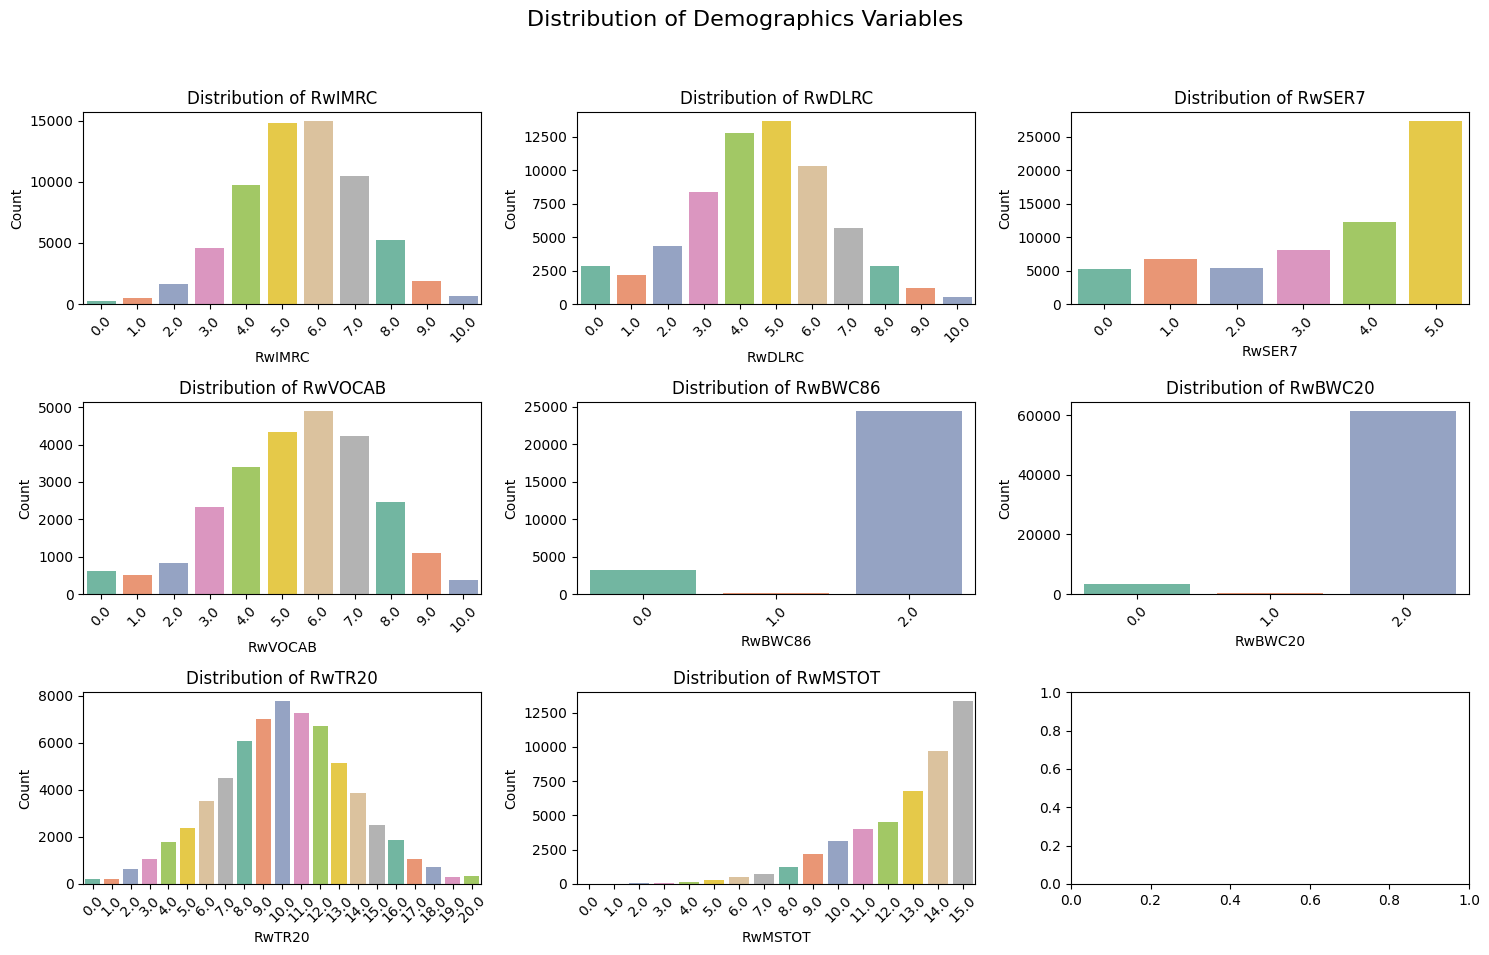

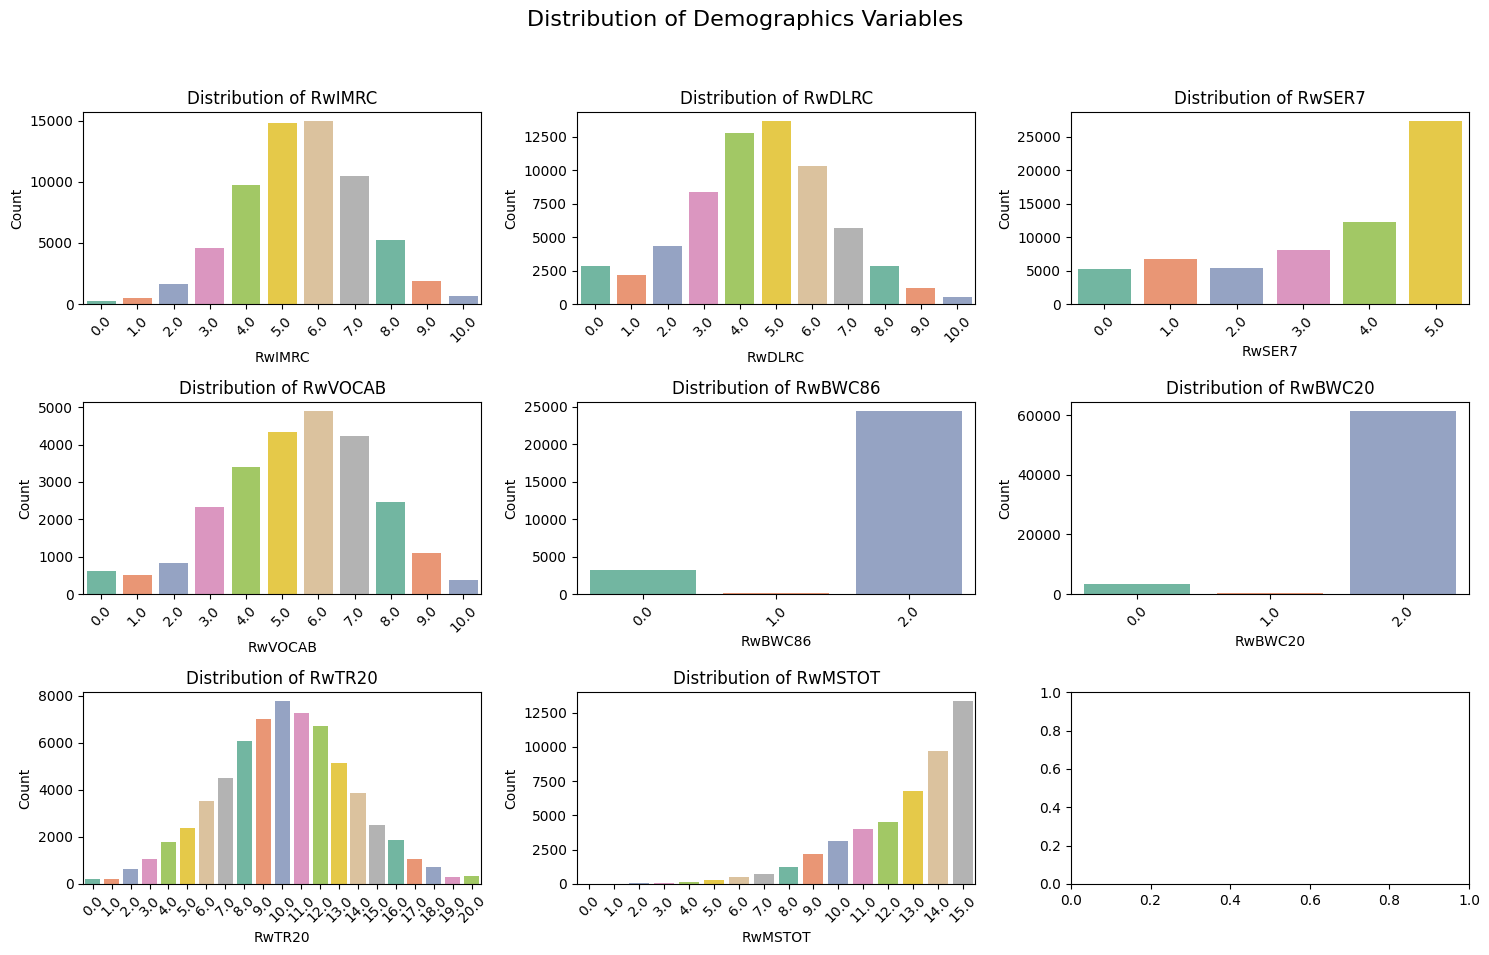

In [55]:
plt.close('all')

import warnings
warnings.filterwarnings('ignore')

# List of variables to plot (first 4 for 2x2 grid)
ngrid = 2
for page in range(0, ngrid):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    fig.suptitle("Distribution of Demographics Variables", fontsize=16)

    hrsByWave[cogniScore] = hrsByWave[cogniScore].astype(float)  # Ensure all cogniScore columns are float for plotting
    for idx, col in enumerate(cogniScore):
        ax = axes[idx // 3, idx % 3]
        if col in ["R1AGEM_B", "RAEDYRS"]:
            sns.histplot(data=hrsByWave, x=col, bins=50, kde=True, color="blue", ax=ax)
        else:
            sns.countplot(data=hrsByWave, x=col, palette="Set2", ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**Observations**:

1. Numerical measures, except for left schewed mental status score and series 7, are normally distributed vidually. We can assume normal distribution and test the assumption rigorously.
2. For counting backgrounds, over 90% people can get this right at the first place (2.0), only small proportion ccould not get them right in both attempts.
3. For series 7, around half of participants could corretly substract 7 from given numbers. For Mental Status Index, over 50% of people scored no less than 13.

For numerical scores, we can convert them to bands, and plot each band's employment and demographical scores to investigate correlations.

## 4.2 Cognitive Impairement with All Waves Pooled

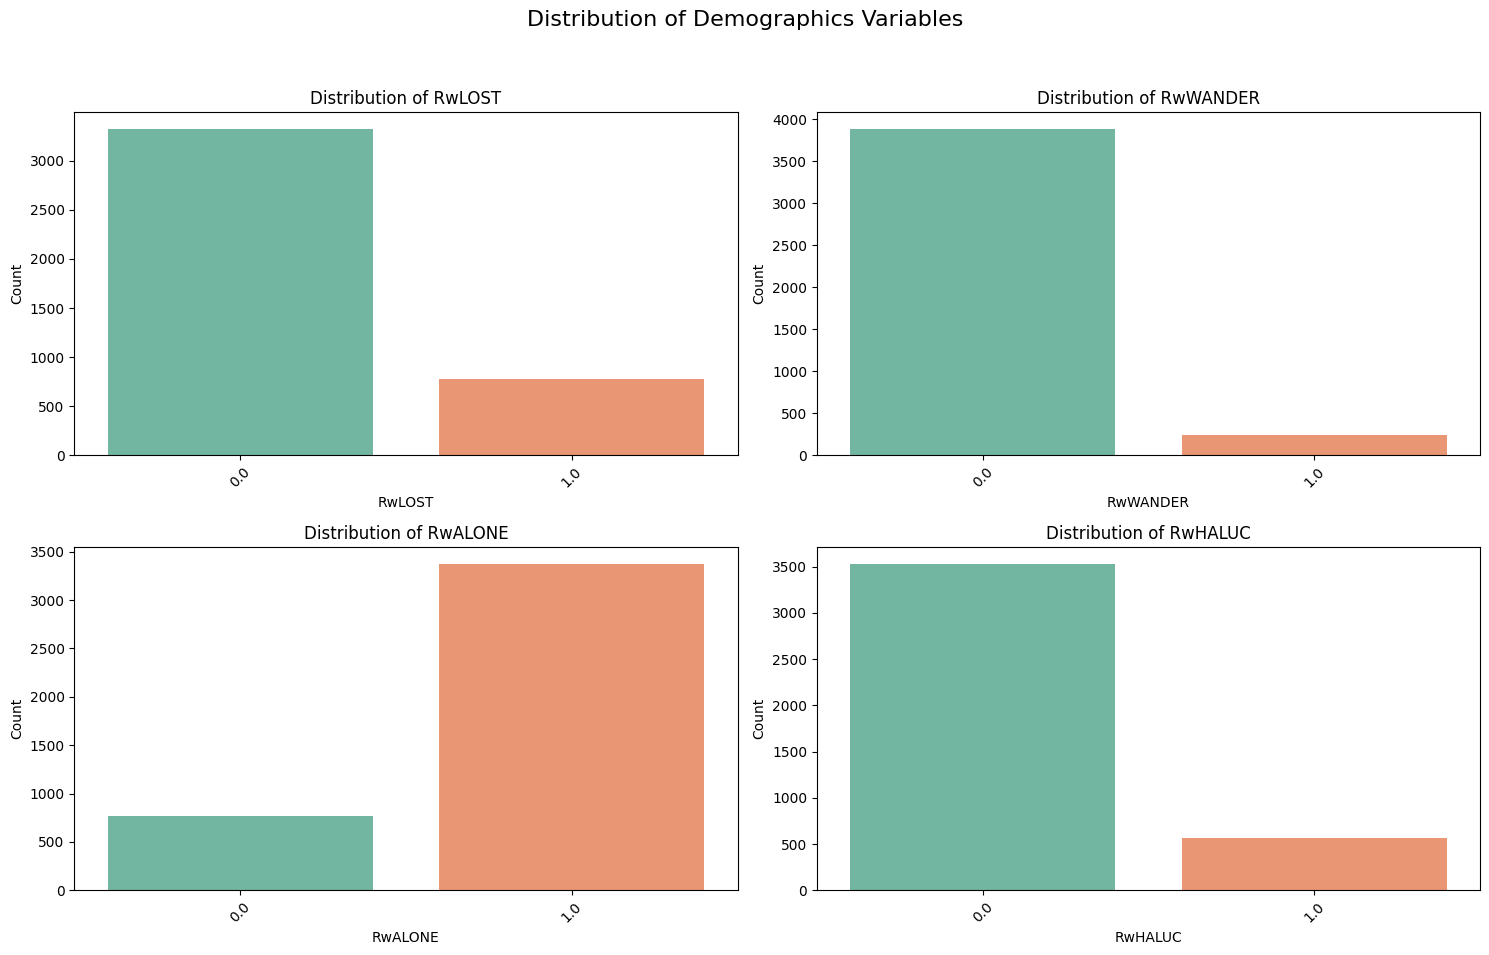

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Distribution of Demographics Variables", fontsize=16)

for idx, col in enumerate(cogniImpr):
        ax = axes[idx // 2, idx % 2]
        sns.countplot(data=hrsByWave, x=col, palette="Set2", ax=ax)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

All cognitive impairments except for "leaving alone" have 0 as the majority group, meaning that most elderlies were not lost, didn't wander, and did't hallucinate. Morever, more elderlies who can be left alone, meaning that family members are confident that the elderly can ensure their own security when no one is around them. These are optimistic signs that elderlies can continue working after the age of retirement.

# 5. Correlation with Demographics

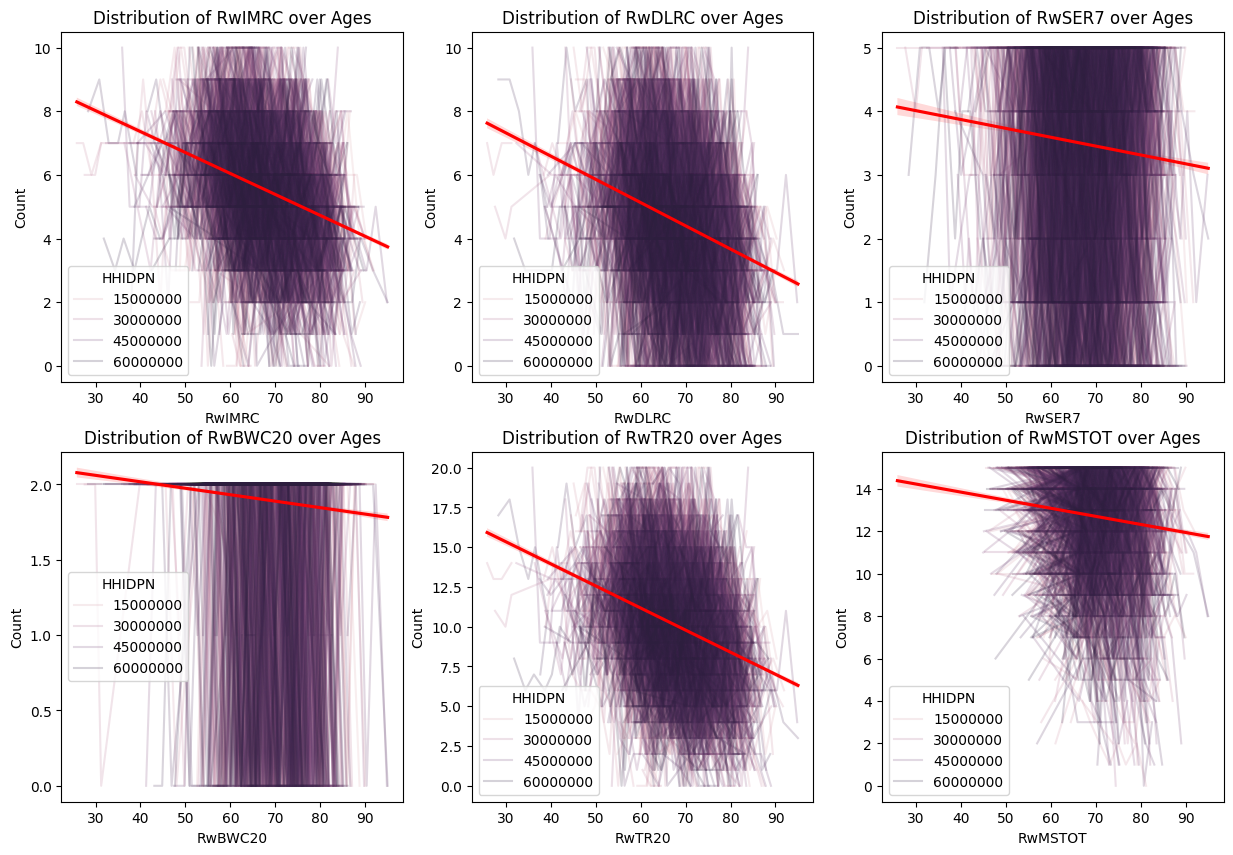

In [112]:
## First, convert age in months to age in years
# hrsByWave["RwAGEM_B"] = hrsByWave["RwAGEM_B"] / 12
## Sample 3000 HHIDPN
sampleHHIDPN = hrsByWave["HHIDPN"].sample(n=3000, random_state = 0)
hrsByWaveSample = hrsByWave.loc[hrsByWave["HHIDPN"].isin(sampleHHIDPN),:]
## Plot the distribution of cognitive scores over ages
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, col in enumerate([cogniScore[i] for i in [0,1,2, 5, 6, 7]]):
    ax = axes[idx//3, idx%3]
    if hrsByWaveSample[col].dtype ==  "float64":
        sns.lineplot(data=hrsByWaveSample, x="RwAGEM_B", y=col, hue="HHIDPN",
                     ax=ax, color='blue', alpha=0.2)
        sns.regplot(data=hrsByWaveSample, x="RwAGEM_B", y=col, ax=ax, color='red', scatter=False)
        ax.set_title(f"Distribution of {col} over Ages")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

**Observations**:

1. The overall trend is that immediate and delayed recall ability declines with aging.
2. Random noise is quite severe in data
3. 


In [129]:
sampleHHIDPN = hrsByWave["HHIDPN"].sample(n=3000, random_state = 0)
hrsByWaveSample = hrsByWave.loc[hrsByWave["HHIDPN"].isin(sampleHHIDPN),:]

In [143]:
## Convert cogniScore to bands
def convertToBands(df, colName, bands):
    """
    Divides the series into 4 quartiles and assigns labels to each band.
    This function takes a DataFrame and a column name, and creates a new column with categorical bands based on the specified ranges.
    The bands are defined by the provided list of tuples, where each tuple contains the lower and upper bounds of the band and the corresponding label.
    
    Parameters:
    df (DataFrame): The DataFrame containing the column to convert.
    colName (str): The name of the column to convert.
    bands (float): the number of bands to create
    
    Returns:
    Series: A new column in the DataFrame with categorical bands based on the specified ranges.
    """
    return pd.cut(df[colName], bins=bands, labels=[f"Band {i+1}" for i in range(len(bands)-1)])
    

def convertManyBands(df, metricsList, idCol="HHIDPN"):
    """
    Wrapper function that calls helper functions: convertToBands, converting a list of selected metrics to bands.
    """
    joinedDf = df[idCol + metricsList].copy()

    for metric in metricsList:
        if joinedDf[metric].dtype == "float64":
            joinedDf[metric] = convertToBands(df, metric, [0, 1, 2, 3, 4])
        
    return joinedDf


cogniBands = convertManyBands(hrsByWaveSample, cogniScore, idCol=["HHIDPN", "Wave"])
print(cogniBands.head())
print(cogniBands.info())

    HHIDPN  Wave RwIMRC  RwDLRC  RwSER7 RwVOCAB RwBWC86 RwBWC20 RwTR20 RwMSTOT
16    2010     1    NaN     NaN     NaN     NaN     NaN     NaN    NaN     NaN
17    2010     2    NaN     NaN     NaN     NaN     NaN     NaN    NaN     NaN
18    2010     3    NaN  Band 4  Band 2  Band 3  Band 2  Band 2    NaN     NaN
19    2010     4    NaN  Band 4  Band 1     NaN     NaN  Band 2    NaN     NaN
20    2010     5    NaN  Band 3     NaN  Band 4  Band 2  Band 2    NaN     NaN
<class 'pandas.core.frame.DataFrame'>
Index: 41680 entries, 16 to 159983
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   HHIDPN   41680 non-null  int64   
 1   Wave     41680 non-null  int64   
 2   RwIMRC   4359 non-null   category
 3   RwDLRC   7278 non-null   category
 4   RwSER7   8614 non-null   category
 5   RwVOCAB  1861 non-null   category
 6   RwBWC86  6424 non-null   category
 7   RwBWC20  16344 non-null  category
 8   RwTR20   988 non-null    

In [152]:
demoAndCogni.head()

HHIDPN  RAGENDER  RARACEM  RAEDYRS  RAEVBRN  Wave RwIMRC  RwDLRC  RwSER7  \
0  2010.0       2.0      1.0      8.0      8.0     1    NaN     NaN     NaN   
1  2010.0       2.0      1.0      8.0      8.0     2    NaN     NaN     NaN   
2  2010.0       2.0      1.0      8.0      8.0     3    NaN  Band 4  Band 2   
3  2010.0       2.0      1.0      8.0      8.0     4    NaN  Band 4  Band 1   
4  2010.0       2.0      1.0      8.0      8.0     5    NaN  Band 3     NaN   

  RwVOCAB RwBWC86 RwBWC20 RwTR20 RwMSTOT  
0     NaN     NaN     NaN    NaN     NaN  
1     NaN     NaN     NaN    NaN     NaN  
2  Band 3  Band 2  Band 2    NaN     NaN  
3     NaN     NaN  Band 2    NaN     NaN  
4  Band 4  Band 2  Band 2    NaN     NaN

<Figure size 1000x600 with 0 Axes>

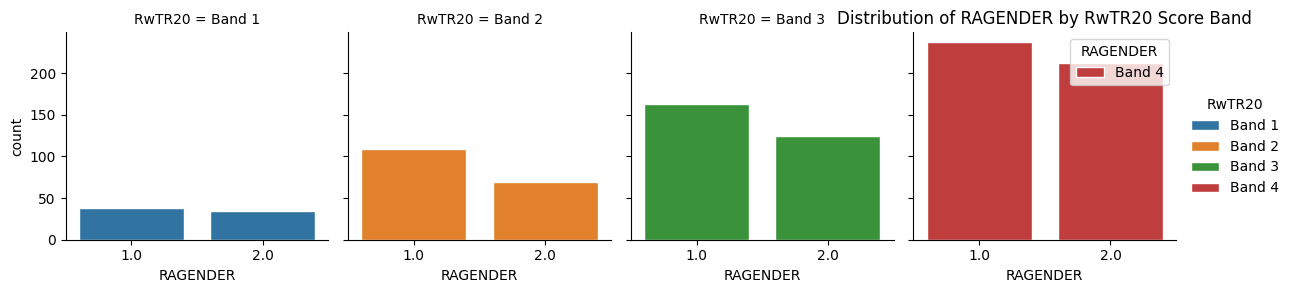

<Figure size 1000x600 with 0 Axes>

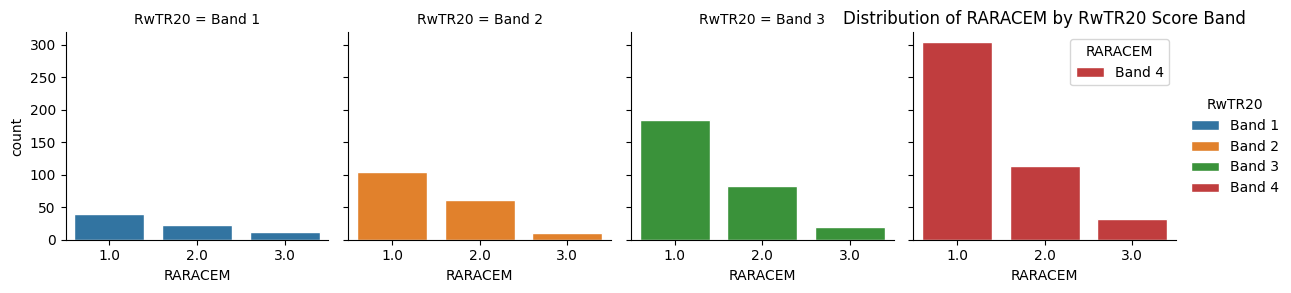

<Figure size 1000x600 with 0 Axes>

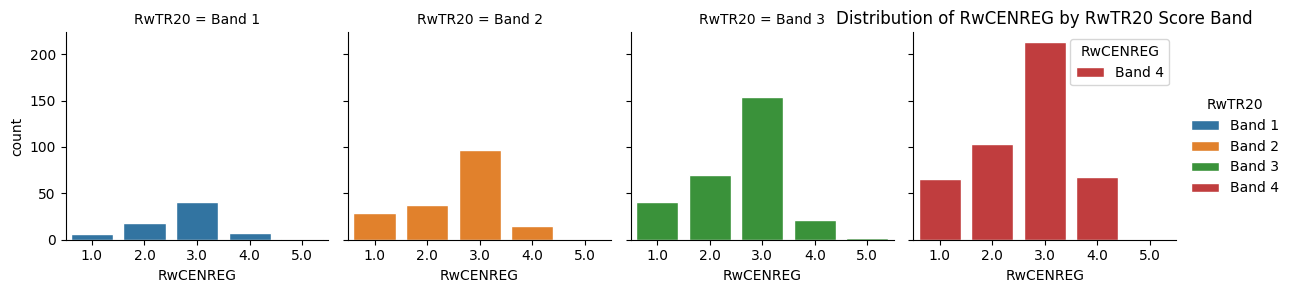

<Figure size 1000x600 with 0 Axes>

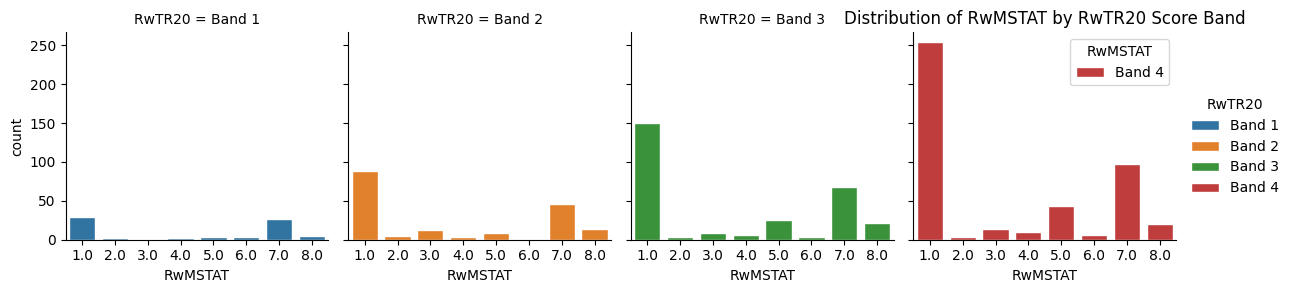

In [159]:
cateDemo = ["RAGENDER", # Reference person gender
            "RARACEM", # Reference person race
            "RwCENREG", # Reference person census region       
            "RwMSTAT", # Reference person marital status
            ]
contDemo = ["RAEDYRS", # Reference person education years
            "RwLIVBRO", # Reference person number of siblings
            "RAEVBRN"]
demoAndCogni = pd.merge(hrsInAll, 
                        pd.concat([cogniBands, hrsByWaveSample[["RwCENREG", "RwMSTAT"]]], axis = 1),
                        how = "right", on=["HHIDPN"])

## for each cognitive scores band, what is the distribition of categorical demographics?
for cateCol in cateDemo:
    plt.figure(figsize=(10, 6))
    # facet by band
    graph = sns.FacetGrid(demoAndCogni, col ="RwTR20",  hue ="RwTR20")
    # map the above form facetgrid with some attributes
    graph.map(sns.countplot, cateCol, edgecolor ="w").add_legend()

    plt.title(f"Distribution of {cateCol} by RwTR20 Score Band")
    plt.xlabel(cateCol)
    plt.ylabel("Count")
    plt.legend(title=cateCol)
    plt.show()   


**Observation in RwTR20**:
1. Demographic distribution status is consistent across different bands. Sample size increase with band number.
2. Men are consistently more than women across bands
3. White Caucasians > Black > Other races
4. Southern region is the mode in all bands of 20-point recall index, implying that conclusion will be biased toward Southern region.
5. Married > Widowed > Never married ordering preserve in all bands.


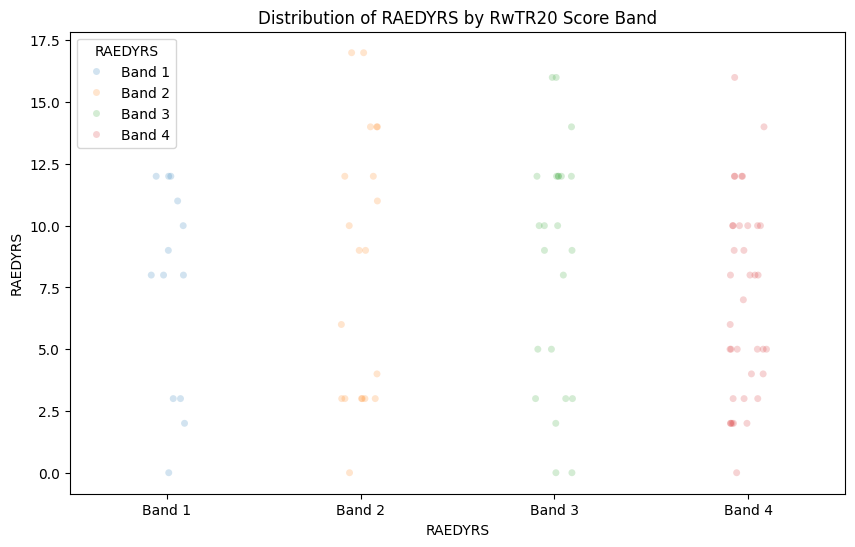

Error plotting RwLIVBRO: Could not interpret value `RwLIVBRO` for `y`. An entry with this name does not appear in `data`.


<Figure size 1000x600 with 0 Axes>

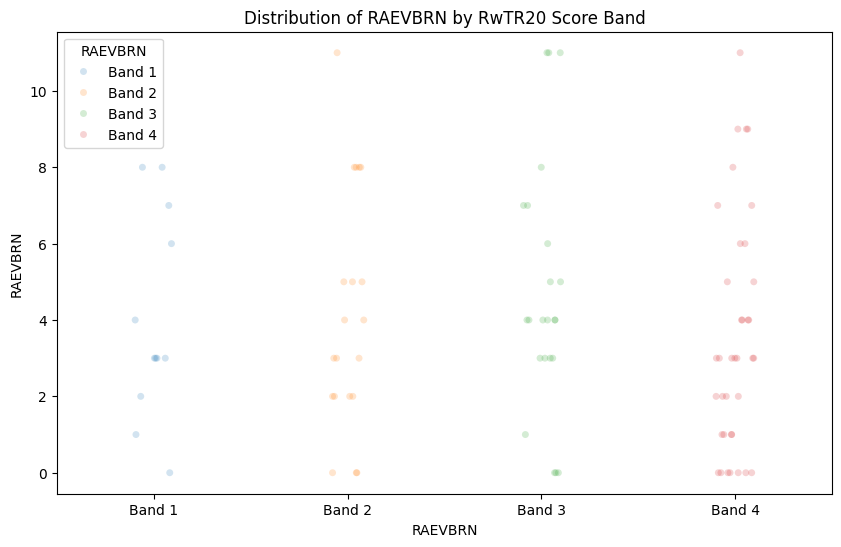

In [172]:
demoAndCogni = pd.merge(hrsInAll, 
                        cogniBands,
                        how = "right", on=["HHIDPN"])

## for each cognitive scores band, what is the distribition of categorical demographics?
for cateCol in contDemo:
    plt.figure(figsize=(10, 6))
    # facet by band
    # graph = sns.FacetGrid(demoAndCogni, col ="RwMSTOT", 
                        #   hue ="RwMSTOT")
    try: 
        sns.stripplot(data = demoAndCogni,x = "RwMSTOT", y = cateCol, hue ="RwMSTOT", alpha = 0.2)
    except ValueError as e:
        print(f"Error plotting {cateCol}: {e}")
        continue

    plt.title(f"Distribution of {cateCol} by RwTR20 Score Band")
    plt.xlabel(cateCol)
    plt.ylabel(cateCol)
    plt.legend(title=cateCol)
    plt.show()   


Correlations between cognitive band and education years did not appear strong, same for the number of children ever born.

# 6. Correlation with Employment

1. Most cognitive status were collected, followed by no response. Only a small portion is imputed by proxy.
2. Around 80-90% of participants are able to count backwards correctly for both sides both round of tests (starting from 20 and 86). This majority is followed by those who are not unable to count backward correctly for at least 1 one time. Those who only counted correctly for 1 time were less common.
3. The mode of vocabulary sum of score is symmetically distributed, concentrated aroudn 5 and 6. However, there is a higher portion of elderlies who cannot remember any words than those who can remember all the words
4. 


**Primary Outcome variables of Interest**: recall index, mental status index, age till cognitive impairments occur, R3LOST, R3LONE, R3HALUC

# 3. Joint Distribution and Correlatedness

## 3.1 Demographic Variables

In [ ]:
# Except R1AGEM_B and RAEDYRS, all the other columns are categorical variables. We will convert them to categorical variables.
hrs["RAGENDER"] = hrs["RAGENDER"].astype("category")
hrs["RARACEM"] = hrs["RARACEM"].astype("category")
hrs["R1CENREG"] = hrs["R1CENREG"].astype("category")
hrs["R1MSTAT"] = hrs["R1MSTAT"].astype("category")
hrs["R1LIVBRO"] = hrs["R1LIVBRO"].astype("category")
hrs["RAEVBRN"] = hrs["RAEVBRN"].astype("category")

## Convert age in months to years
hrs["R1AGEM_B"] = hrs["R1AGEM_B"]/12

C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


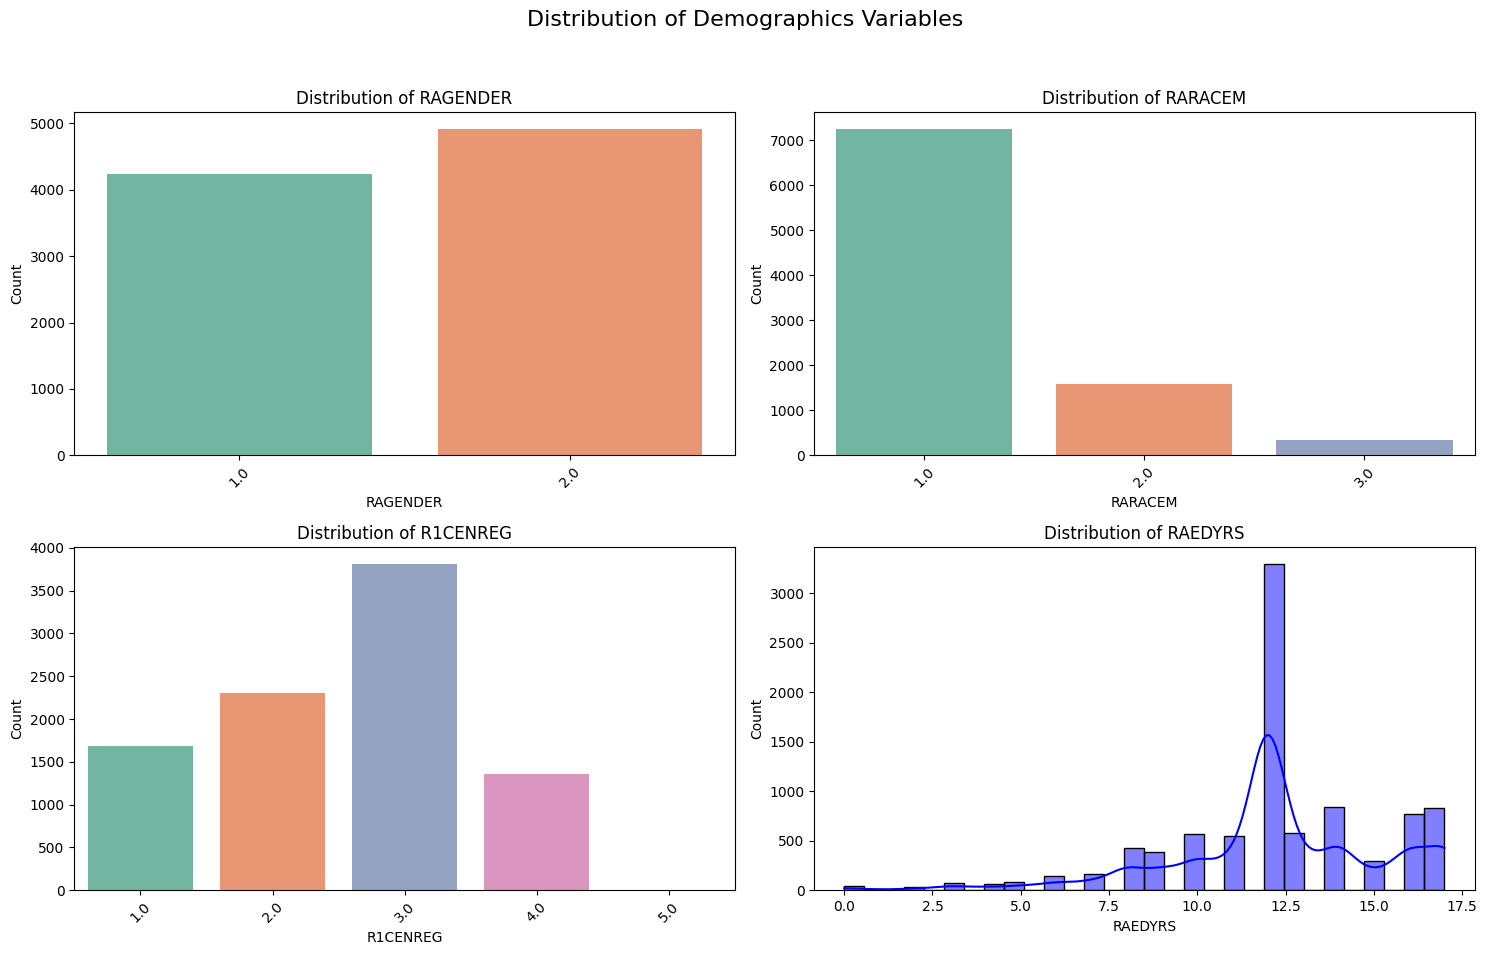

C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of

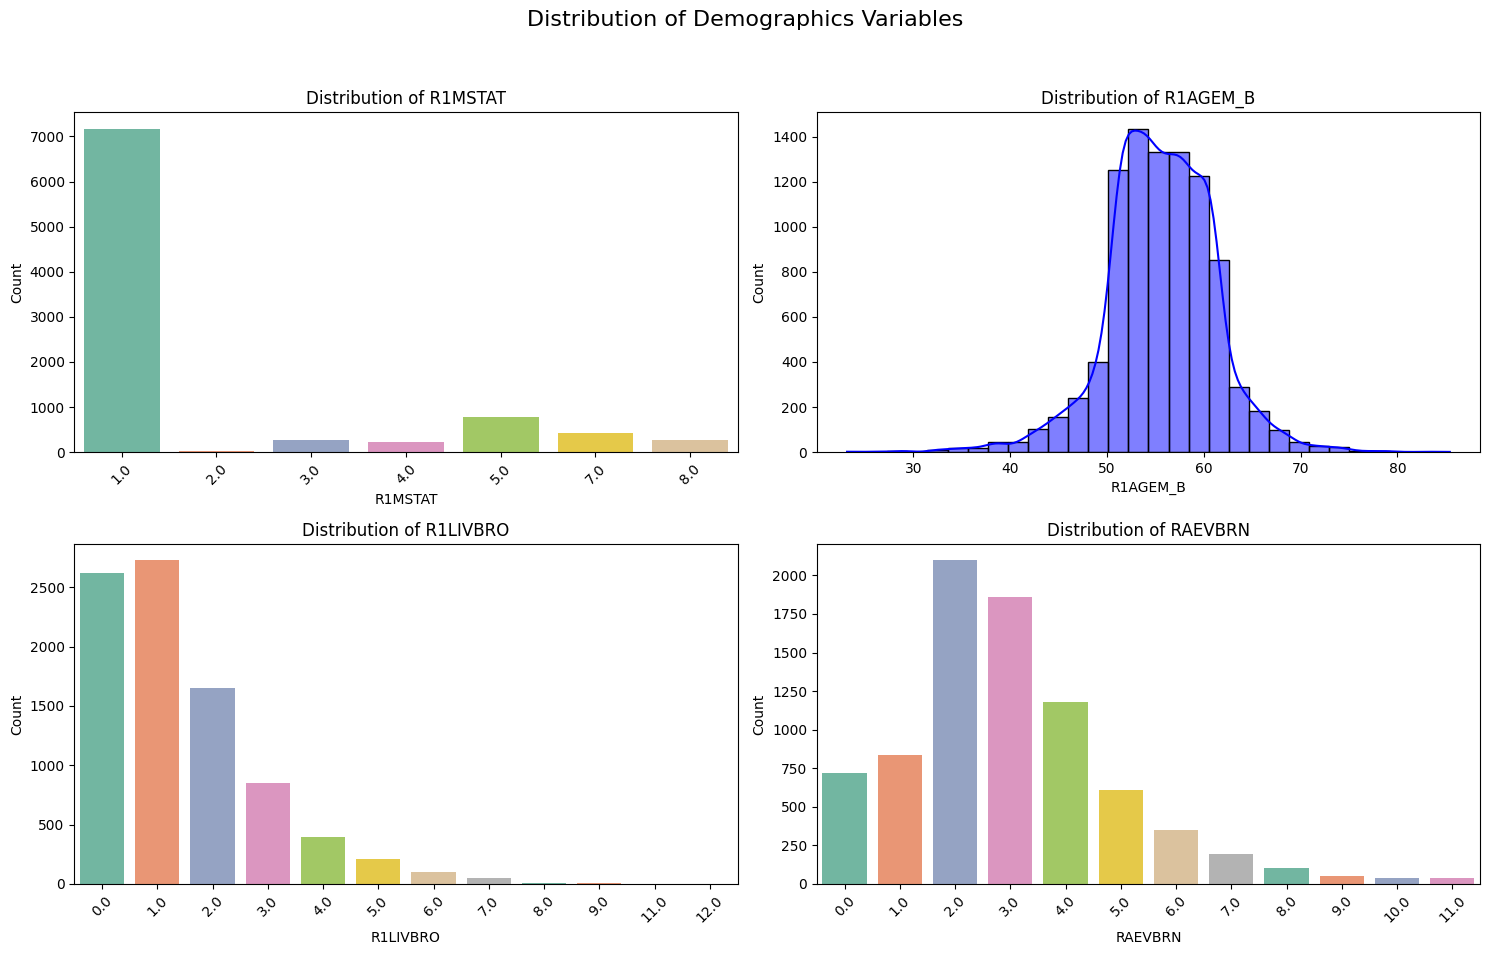

In [ ]:
# Create 4 marginal distribution plots in the same figure
# Clear any existing figures to avoid overlap in Jupyter
plt.close('all')

# List of variables to plot (first 4 for 2x2 grid)
ngrid = 2
for page in range(0, ngrid):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Distribution of Demographics Variables", fontsize=16)

    plot_vars = demographics[page*4:(page*4 + 4)]
    for idx, col in enumerate(plot_vars):
        ax = axes[idx // 2, idx % 2]
        if col in ["R1AGEM_B", "RAEDYRS"]:
            sns.histplot(data=waveOneDemographics, x=col, bins=30, kde=True, color="blue", ax=ax)
        else:
            sns.countplot(data=waveOneDemographics, x=col, palette="Set2", ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Observations:  

**Gender**: there are more females than male  
**Race**: 3 levels; white caucasian take the majority, black take the second place.  
**Census Region**: most came from South Region, followed by Midwest; no one came from Other region  
**Education Years**: mode occur at 12-12.5 years of education (high school graduate or bachelor's degree); if set 12 years as water shed, more people had >12 years of education than people who don't  
**Current Maritial Status**: over 90% are married; the remaining are mostly partnered (probably not married yet, just lived together); around 1-2% are never married  and widowed  
**Number of Marriages**:  
**Age**: symmentrically distributed; mean and median occur around 55 years; need to exclude individuals under 40 years   
**Living Siblings**: most have only 0 or 1 living siblings; the number of people decrease with subling counts   
**Children Born**: over 50% people had 0-4 children in their lifetimes; mode occured at 3 children

In [27]:
waveOneDemographics.R1AGEM_B.dtype == 'float64'


True

C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

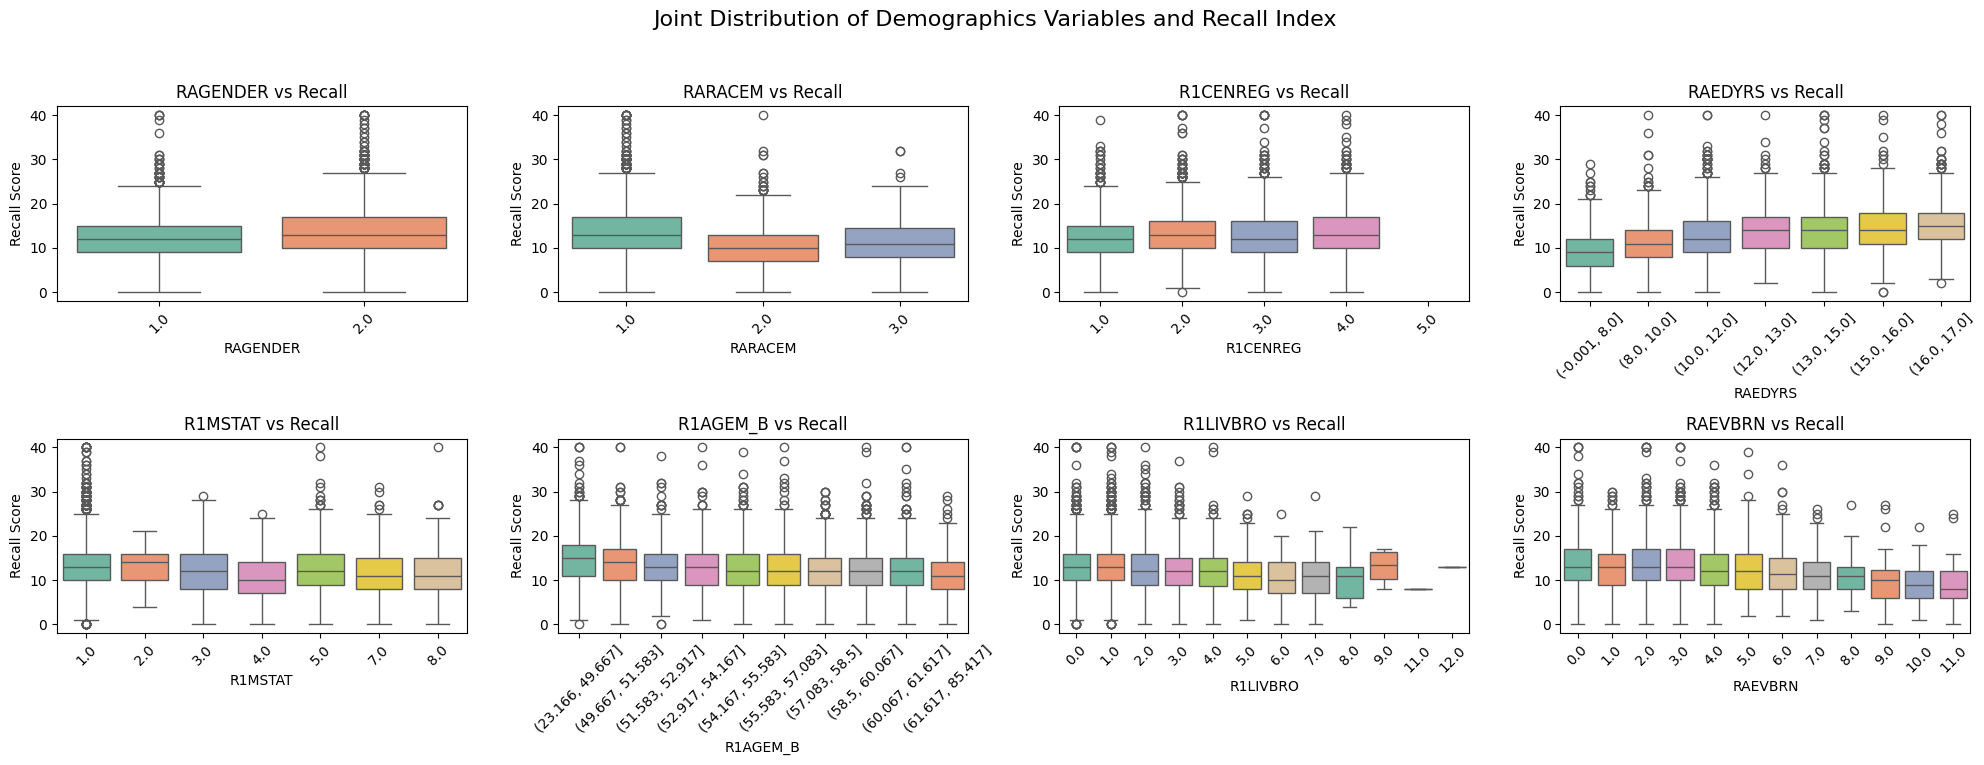

In [31]:
## Automatic plot multiple subplots for the correlation between the outcome variable and other variables
def plot_distribution(plot_vars,data_set, plot_vars_name):
    n_cols = 4
    n_rows = (len(plot_vars) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle("Joint Distribution of "+ plot_vars_name + " Variables and Recall Index", fontsize=16)

    # 把 axes 展平为一维数组，方便遍历
    axes = axes.flatten()

    for idx, col in enumerate(plot_vars):
        ax = axes[idx]
        if data_set[col].dtype == 'float64':
            # For continuous variables, cut it into bins and use boxplot
            binned = pd.qcut(data_set[col], q=10, duplicates='drop')
            sns.boxplot(x=binned, y=data_set[outcomeVars[0]], palette="Set2", ax=ax)
        else:
           # Otherwise, use boxplot for categorical variables
            sns.boxplot(
                data=data_set,
                x=col,
                y=outcomeVars[0],
                ax=ax,
                palette="Set2"
            )
        
        ax.set_title(f"{col} vs Recall")
        ax.set_xlabel(col)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Recall Score")

    # 删除多余的 subplot（如果变量数不是4的倍数）
    for j in range(len(plot_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_distribution(demographics, waveOneDemographics,'Demographics')

Observations:  

**Gender**: females have better recall index than male
**Race**: 3 levels; white caucasians have the the best recall index,black have the worst, other races are in between.
**Census Region**: among all well-known regions, a little difference in recall index is observed between regions
**Education Years**: the recall index improves with educational years; the increment diminishes as the years increases; high school graduates (12~13 years) roughly have the same recall performance as bachelors (13-17 years)
**Current Maritial Status**: very little difference in between different maritial status
**Age**: recall index slowly decreases with the age, from a median of 16 words for age in 23~49 to 61.85 to 11 words in age 61 to 85
**Living Siblings**: non-linear relationships between the recall and count of living siblings, the best performance occurs at 0 and 12 siblings, and worst performance occur at 6 silings  
**Children Born**: slowly declining performances with the number of children ever borned

Next step: 

Pay special attention to 

1. Age: exclude individuals under age 55; ANOVA
2. Years of education: ANOVA analysis
3. Number of Living Siblings: spline fitting
4. Number of Children Every Born: spline fitting; ANOVA

## 3.2 Primary Variables of Interest

In [32]:
employmentVars = [
    "R1WORK", # W1 R working for pay
    "R1JHOURS", # W1 Hours worked/week main job
    "R1WGIHR", # W1 Imputed Wage Rate-Hrly
    "R1JCOCC", # W1 Current Job Occup/1980 Census
    "R1JPHYS", # W1 Cur job req lots phys effort Categ
    "R1JLIFT", # W1 Cur job req lift heavy loads
    "R1JSTRES", # W1 Cur job involves much stress
    "R1JSTOOP", # W1 Cur job req stoop/kneel/crouch
    "R1JSIGHT", # W1 Cur job req good eyesight
]

waveOneEmployment = waveOne[outcomeVars+employmentVars]
waveOneEmployment = pd.concat([waveOne["HHIDPN"], waveOneEmployment], axis=1)
waveOneEmployment = waveOneEmployment[hrsFull["INW1"] == 1] ## Only keep the participants who responded in the first wave
print(waveOneEmployment.head())
print(waveOneEmployment.shape)
print(waveOneEmployment.info())
# print(waveOneEmployment.isna().sum())

       HHIDPN  R1TR40  R1WORK  R1JHOURS    R1WGIHR  R1JCOCC  R1JPHYS  R1JLIFT  \
0      1010.0    17.0     1.0      40.0  15.000000      7.0      3.0      4.0   
1      2010.0    19.0     0.0       NaN        NaN      NaN      NaN      NaN   
2      3010.0    11.0     1.0      40.0  22.000000     13.0      2.0      2.0   
3      3020.0    21.0     1.0      15.0   4.500000      3.0      2.0      3.0   
4  10001010.0     8.0     0.0       NaN   5.452073      NaN      NaN      NaN   

   R1JSTRES  R1JSTOOP  R1JSIGHT  
0       4.0       4.0       2.0  
1       NaN       NaN       NaN  
2       2.0       1.0       2.0  
3       3.0       3.0       2.0  
4       NaN       NaN       NaN  
(9158, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 9158 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HHIDPN    9158 non-null   float64
 1   R1TR40    8707 non-null   float64
 2   R1WORK    9146 non-null   float64
 

C:\Users\86139\AppData\Local\Temp\ipykernel_12864\872295296.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  waveOneEmployment = waveOneEmployment[hrsFull["INW1"] == 1] ## Only keep the participants who responded in the first wave


In [ ]:
waveOneEmployment.loc[:, ~waveOneEmployment.columns.isin(["HHIDPN", "R1JHOURS", "R1WGIHR"])] = waveOneEmployment.loc[:, ~waveOneEmployment.columns.isin(["HHIDPN", "R1JHOURS", "R1WGIHR"])].astype("category")

C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=binned, y=data_set[outcomeVars[0]], palette="Set2", ax=ax)
C:\Users\86139\AppData\Local\Temp\ipykernel_12864\2792420791.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. aft

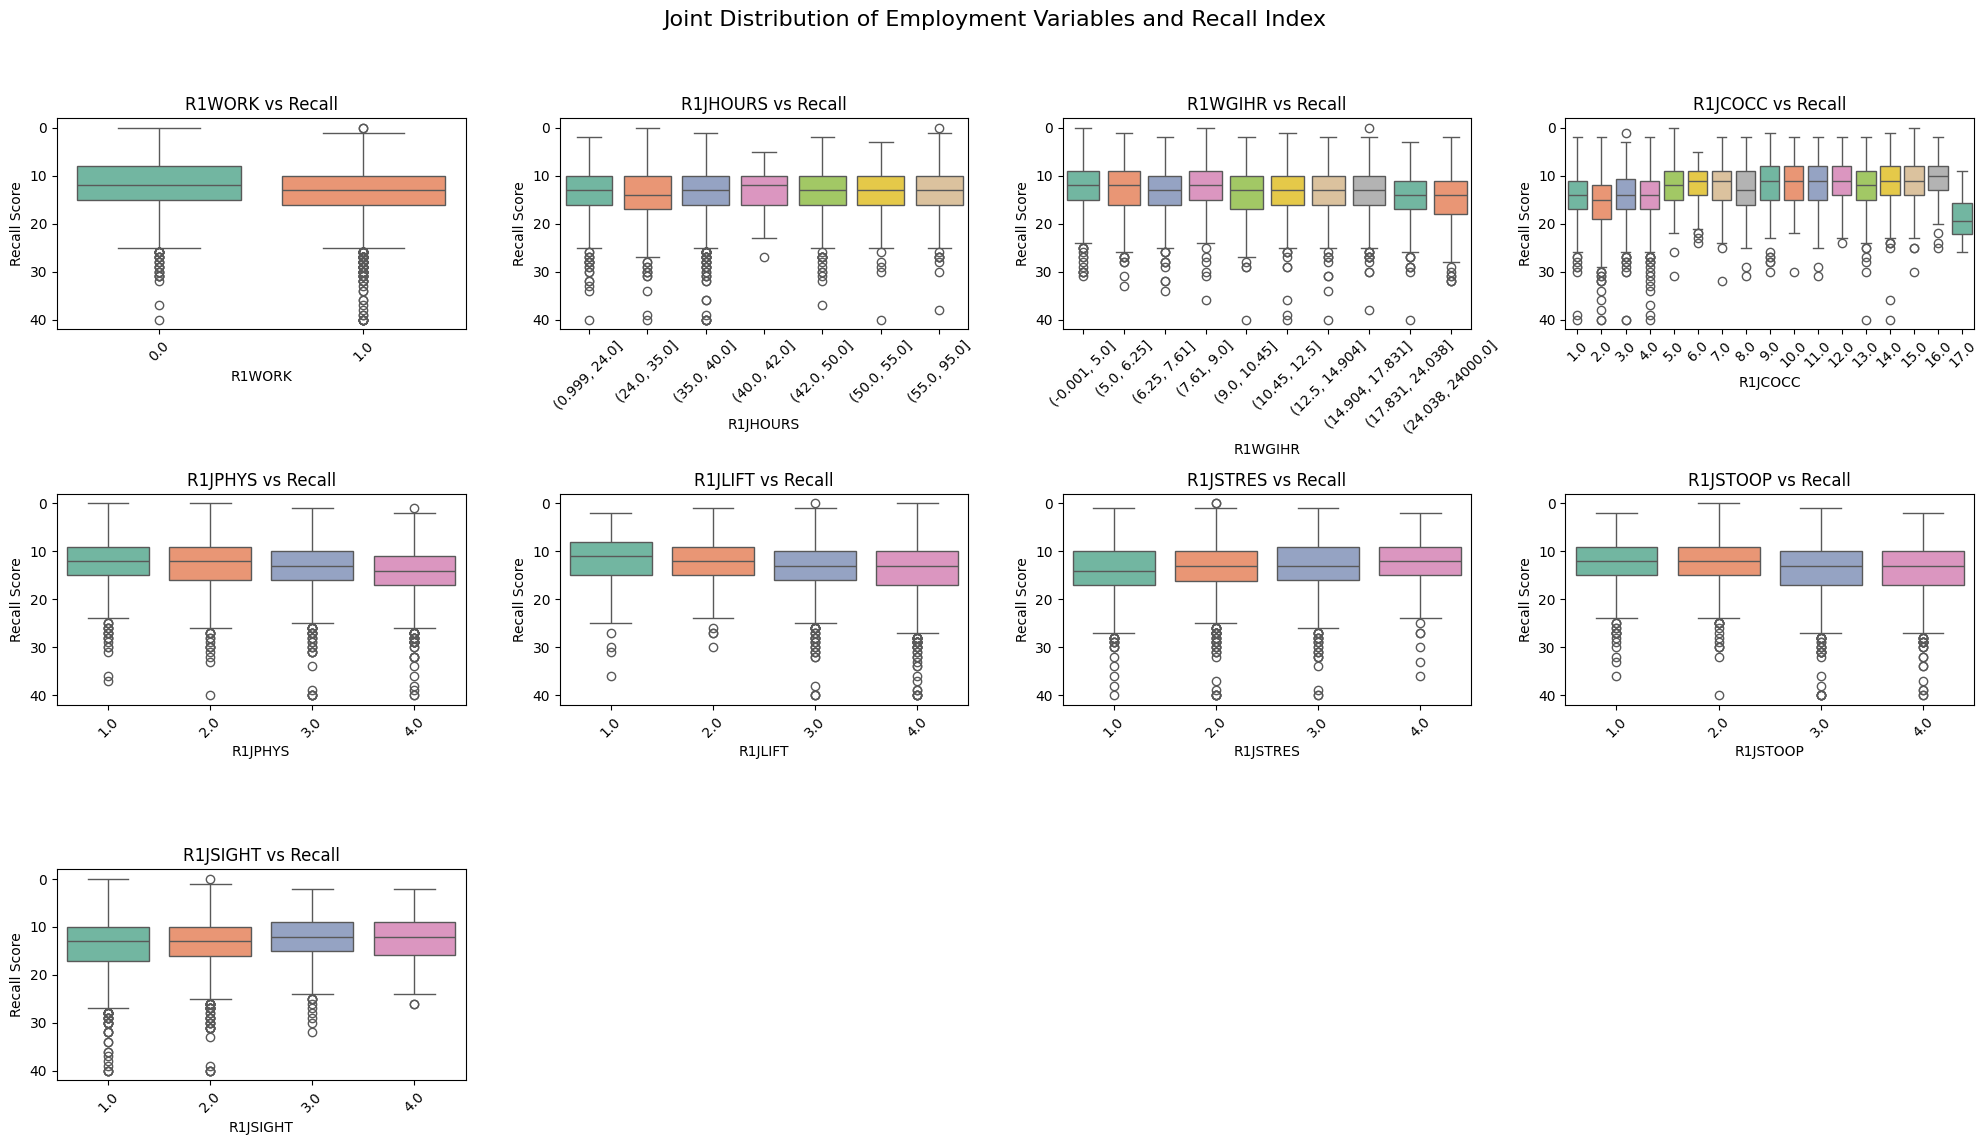

In [44]:
## Box Plot to inspect relationship between employment variables and recall index, with spread quantified
plot_distribution(employmentVars, waveOneEmployment,'Employment')

Observations:  
A lot of variability in Recall Index exists even conditioned in employment status variables.
Weak association between recall index and employment metrics.

**Employment Status**: people who are working for pay have slighly higher recall index than who don't.  
**Occupation Catgeory**: members of armed forces have better recall index than the rest; professional specialty opr/tech, clerical/admin supp, precison production, and operators:machine tend to have top tier outliers.  
**Wage Rate**: very weak relationship  
**Work Hours**: very weak non-linear relationship   
**Phyical Effort**: recall index decrease as physical effort required increases.   
**Lifting**: same trend as phyical effort   
**Stress**: recall index increase with stress     
**Stoping, Kneeling**: recall index decrease with stooping, kneeling, etc   
**Eyesight**: recall index decrease with eyesight requirement  

## 3.3 Socioeconomic Variables

### 3.31 Saving Variables

In [15]:
outcomeVars = [
    "R1TR40" # W1 TOTAL WORD RECALL SUMMARY SCORE
]
SavingVars = [
    "H1ARLES", # Net value of real estate(not primary residence)
    "H1ATRAN", # Net Value Of Vehicles
    "H1ABSNS", # Net Value Of Businesses
    "H1AIRA", # Net value of IRA,Keogh Accounts
    "H1ASTCK", # Net Value Of Stocks,mutual funds,and investment trusts
    "H1ACHCK", # Value Of Checking,savings,or money market accounts
    "H1ACD", # Value of,government savings bonds,and T-bills
    "H1ABOND", # Net Value Of Bonds And Bond Funds
    "H1AOTHR", # Net value of all other savings
    "H1ADEBT", # Value Of Other Debt
    "H1AHOUS", # Value Of Primary Residence
    "H1AMORT", # Value Of All Mortgages/land contracts(primary residence)
    "H1AHMLN", # Value Of Other Home Loans(primary residence)
    "H1ATOTH", # Value Of Other Home Loans(primary residence)
    "H1ATOTB", # Total Wealth
]

# waveOneEmployment = hrsFull.filter(outcomeVars+employmentVars)
# waveOneEmployment = pd.concat([waveOne["HHIDPN"], waveOneEmployment], axis=1)
# waveOneEmployment = waveOneEmployment[hrsFull["INW1"] == 1] ## Only keep the participants who responded in the first wave
# print(waveOneEmployment.head())
# print(waveOneEmployment.shape)
# print(waveOneEmployment.info())
# print(waveOneEmployment.isna().sum())



waveOneSaving = hrsFull.loc[hrsFull["INW1"] == 1, ["HHIDPN"] + outcomeVars + SavingVars]

print(waveOneSaving.head())
print(waveOneSaving.shape)
print(waveOneSaving.info())
print(waveOneSaving.isna().any(axis=1).sum())


       HHIDPN  R1TR40  H1ARLES  H1ATRAN  H1ABSNS   H1AIRA  H1ASTCK  H1ACHCK  \
0      1010.0    17.0      0.0   1000.0      0.0      0.0      0.0   5000.0   
1      2010.0    19.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      3010.0    11.0   3000.0   4000.0      0.0  30000.0      0.0  10000.0   
3      3020.0    21.0   3000.0   4000.0      0.0  30000.0      0.0  10000.0   
4  10001010.0     8.0      0.0      0.0      0.0      0.0      0.0   7000.0   

    H1ACD  H1ABOND  H1AOTHR  H1ADEBT   H1AHOUS  H1AMORT  H1AHMLN   H1ATOTH  \
0     0.0      0.0      0.0      0.0       0.0      0.0      0.0       0.0   
1     0.0      0.0      0.0      0.0       0.0      0.0      0.0       0.0   
2  8000.0      0.0      0.0      0.0  100000.0      0.0      0.0  100000.0   
3  8000.0      0.0      0.0      0.0  100000.0      0.0      0.0  100000.0   
4     0.0      0.0      0.0      0.0       0.0      0.0      0.0       0.0   

    H1ATOTB  
0    6000.0  
1       0.0  
2  155000.0  


Cross Wave Differences in Original HRS Data
See cross-wave differences for the components:
        HwAHOUS=value of primary residence
        HwANETHB=netvalue of secondary residence
        HwARLES=netvalue of real estate (not primary residence)
        HwATRAN=netvalue of vehicles
        HwABSNS=netvalue of businesses
        HwASTCK=netvalue of stocks, mutual funds, and investment trusts
        HwACHCK=value of checking, savings, or money market accounts
        HwACD=value of CD, government savings bonds, and T-bills
        HwABOND=netvalue of bonds and bond funds
        HwAOTHR=netvalue of all other savings
        HwAMORT=valueof all mortgages/land contracts (primary residence)
        HwAHMLN=valueofother home loans (primary residence)
        HwADEBT=value of other deb

c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packa

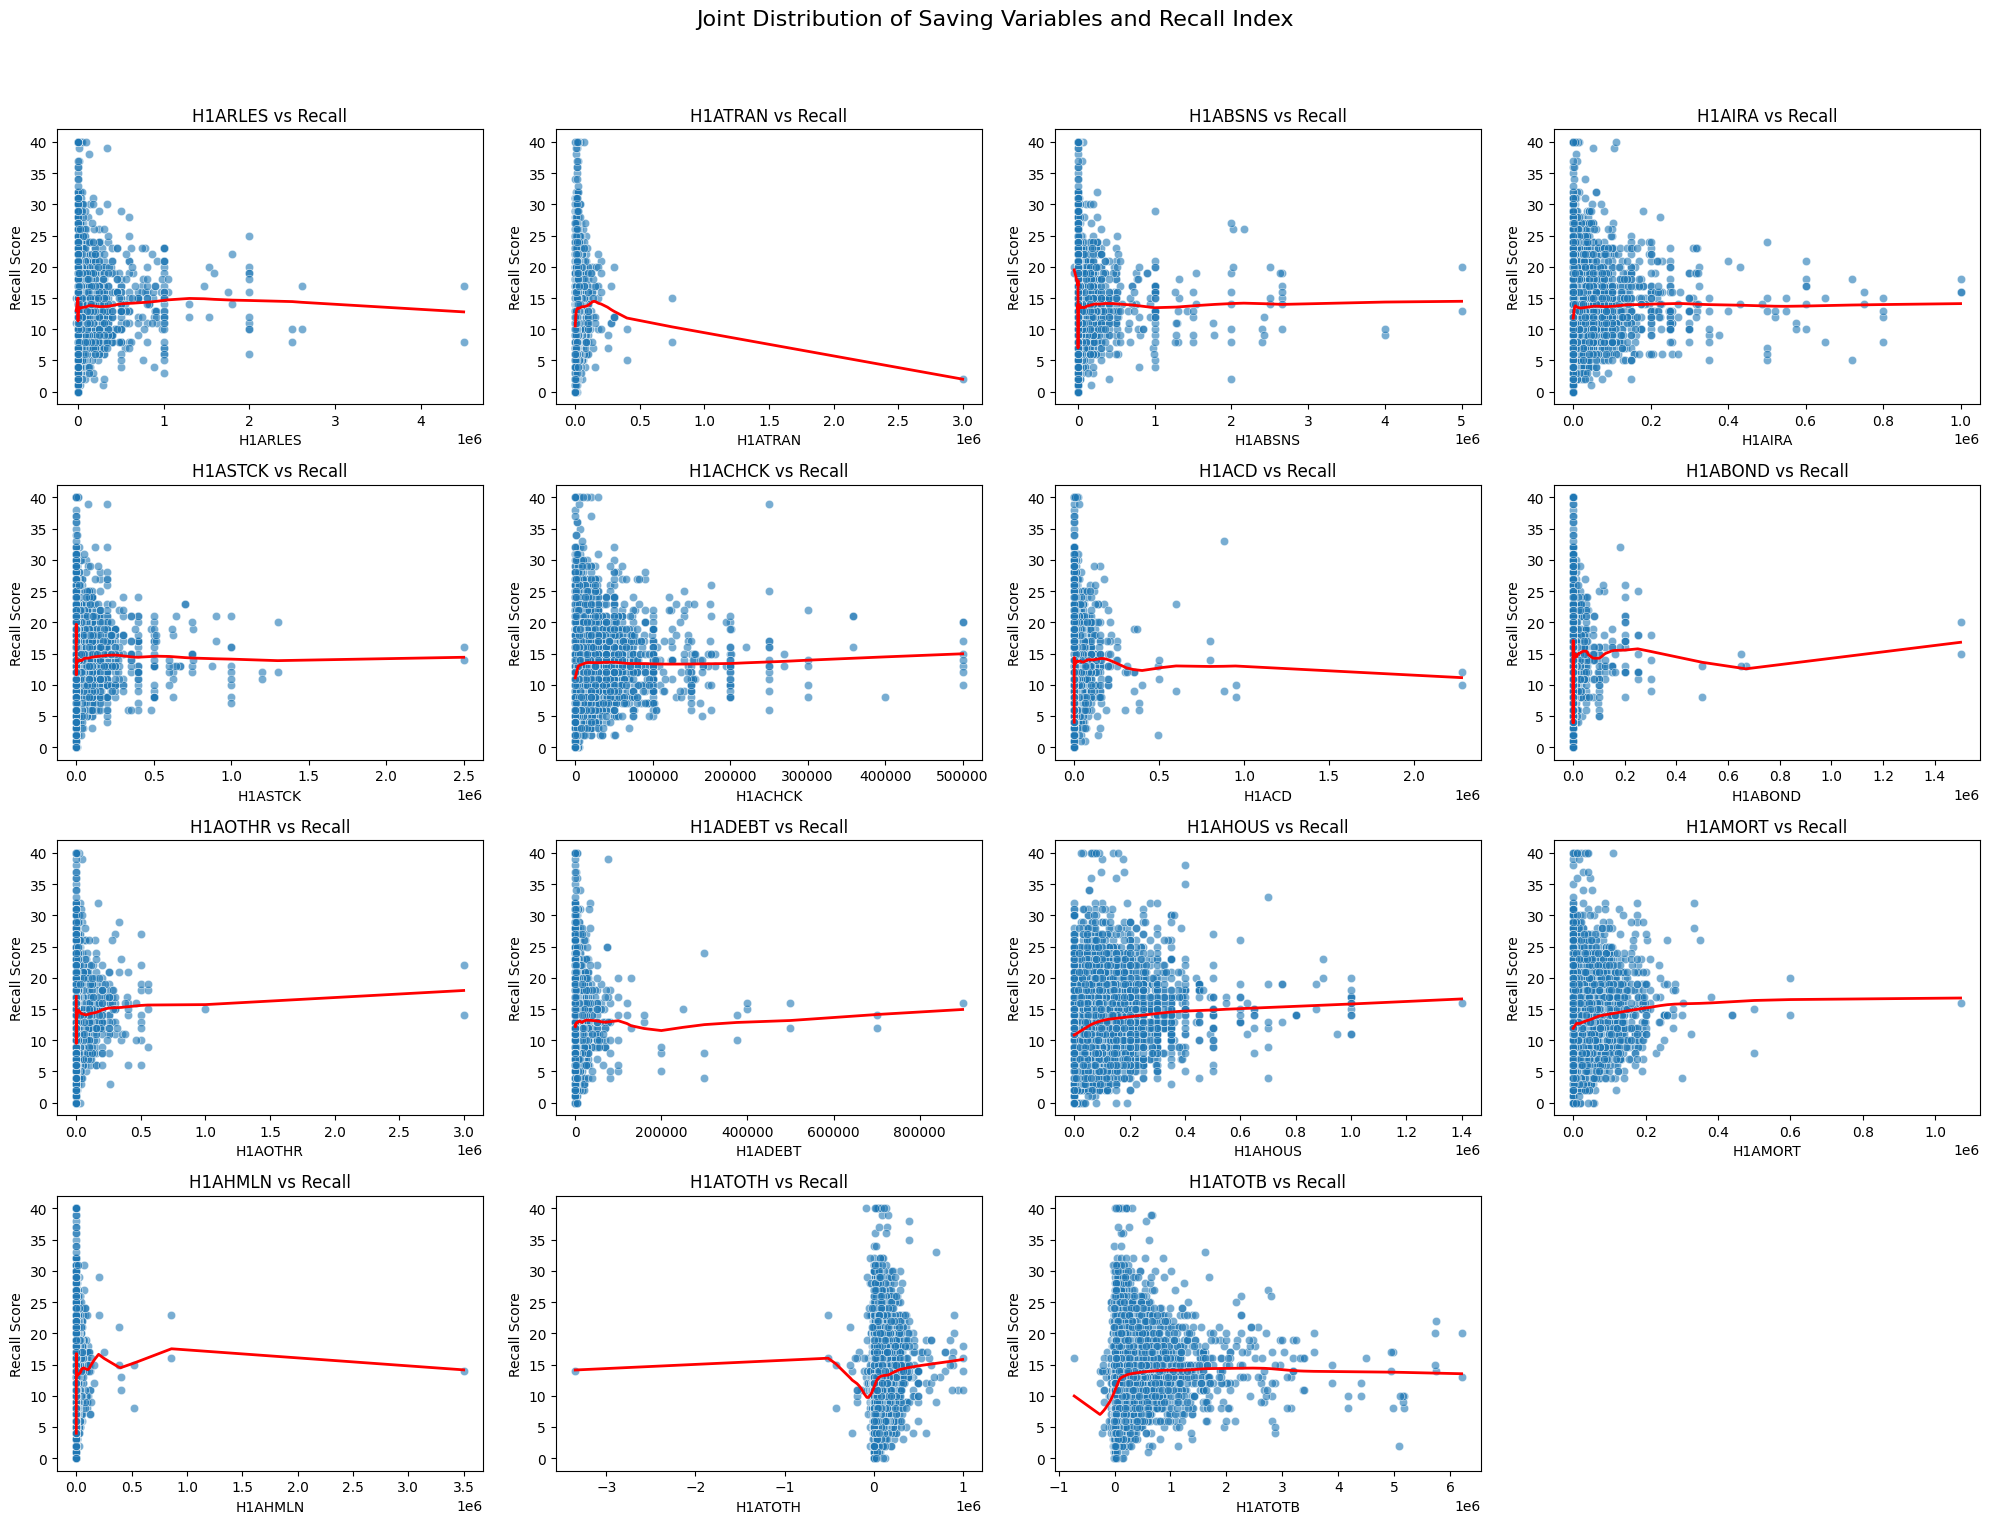

In [22]:
def plot_distribution(plot_vars,data_set,plot_vars_name=''):
    n_cols = 4
    n_rows = (len(plot_vars) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle("Joint Distribution of "+ plot_vars_name + " Variables and Recall Index", fontsize=16)

    # 把 axes 展平为一维数组，方便遍历
    axes = axes.flatten()

    for idx, col in enumerate(plot_vars):
        ax = axes[idx]
        sns.scatterplot(
            data=data_set,
            x=col,
            y=outcomeVars[0],
            ax=ax,
            alpha=0.6
        )
        sns.regplot(
            data=data_set,
            x=col,
            y=outcomeVars[0],
            scatter=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 2},
            ax=ax
        )
        ax.set_title(f"{col} vs Recall")
        ax.set_xlabel(col)
        ax.set_ylabel("Recall Score")

    # 删除多余的 subplot（如果变量数不是4的倍数）
    for j in range(len(plot_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_distribution(SavingVars,waveOneSaving,'Saving')

C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=binned, y=data_set[outcomeVars[0]], palette="Set2", ax=ax)
C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=binned, y=data_set[outcomeVars[0]], palette="Set2", ax=ax)
C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:48: UserWarning: set_ticklabels(

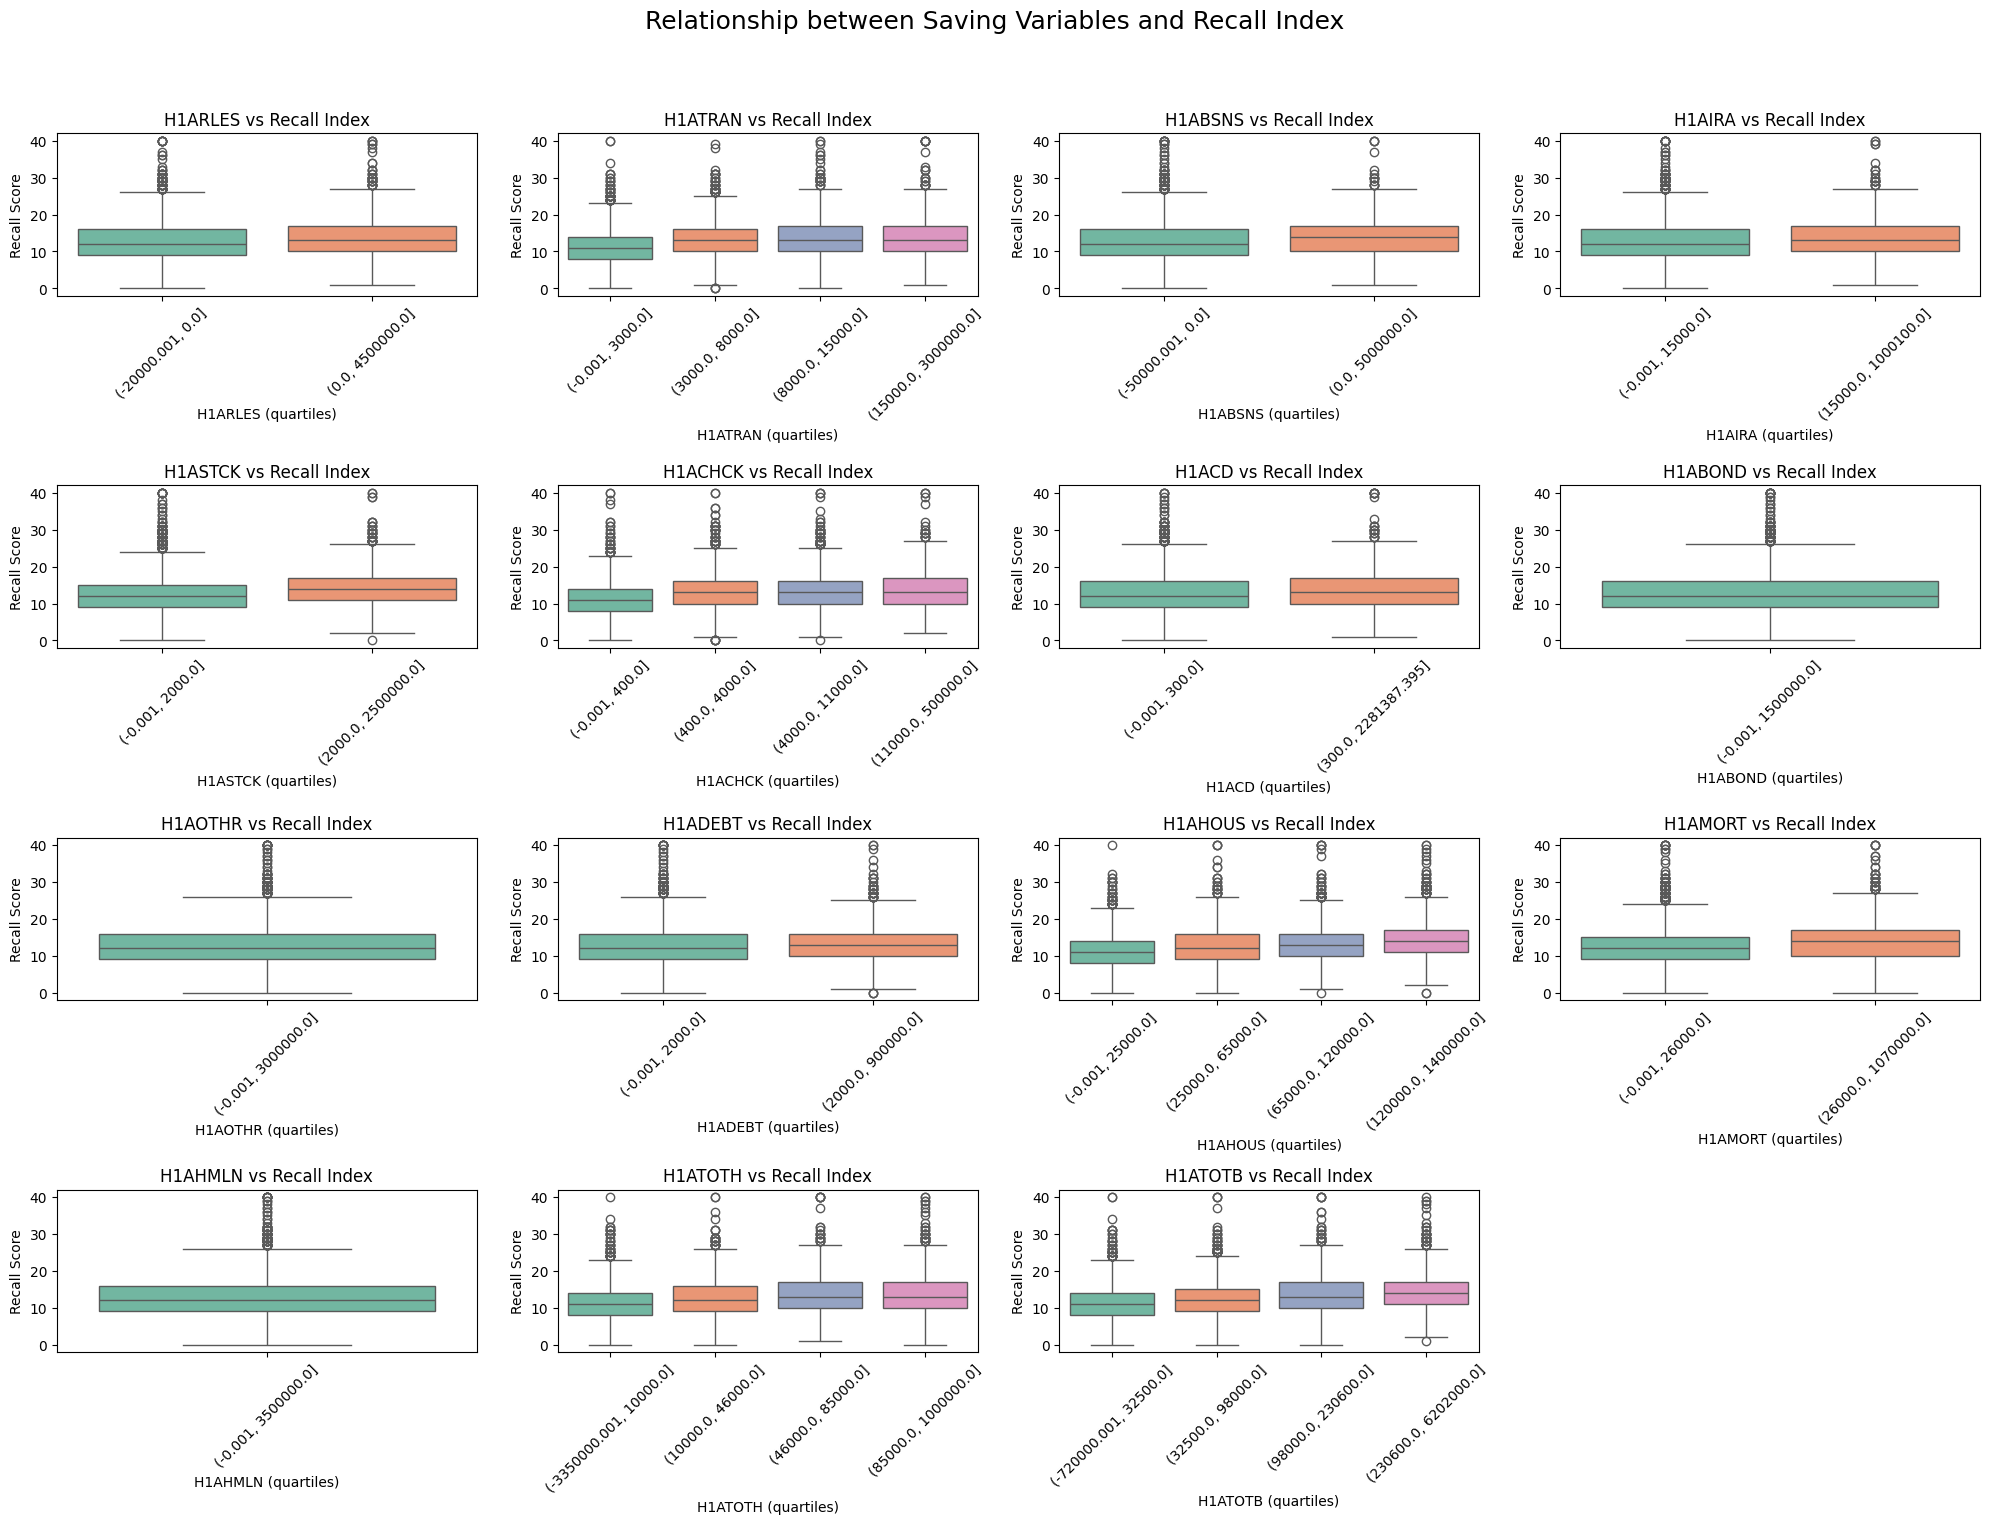

In [ ]:
def plot_relationship(plot_vars,data_set,plot_vars_name=''):
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle("Relationship between "+plot_vars_name+" Variables and Recall Index", fontsize=18)

    axes = axes.flatten()

    for idx, col in enumerate(plot_vars):
        ax = axes[idx]

        # 处理变量缺失或无法分箱情况
        try:
            # 将连续变量分成四个分位数组别
            binned = pd.qcut(data_set[col], q=4, duplicates='drop')
            sns.boxplot(x=binned, y=data_set[outcomeVars[0]], palette="Set2", ax=ax)
            ax.set_xlabel(f"{col} (quartiles)")
            ax.set_ylabel("Recall Score")
            ax.set_title(f"{col} vs Recall Index")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center')
            ax.set_title(f"{col} - Error")
            ax.axis("off")  # 可选：关闭错误图表的坐标轴

    # 删除多余子图
    for j in range(len(plot_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_relationship(SavingVars,waveOneSaving,'Saving')

### 3.32 Income

In [25]:
outcomeVars = [
    "R1TR40" # W1 TOTAL WORD RECALL SUMMARY SCORE
]
IncomeVars = [
    "R1IEARN", #  Individual Earnings
    "H1ICAP", # Household Capital Income
    "R1IPENA", # Individual Income from Employer Pension or Annuity
    "R1ISSDI", # Individual Income from Social Security DI or SSI
    "R1ISRET", # Individual Income from Social Security Retirement
    "R1IUNWC", # Individual Unemployment or Workers Compensation
    "R1IGXFR", # Individual Income From Other Government Transfers
    "H1IOTHR", # All Other Household Income
    "H1ITOT", # Total Household Income(Respondent & Spouse)
    "H2IIRAWY1", # IRA Withdrawals
    "H1INPOV", # Poverty Threshold/Whether in Poverty
]

# waveOneEmployment = hrsFull.filter(outcomeVars+employmentVars)
# waveOneEmployment = pd.concat([waveOne["HHIDPN"], waveOneEmployment], axis=1)
# waveOneEmployment = waveOneEmployment[hrsFull["INW1"] == 1] ## Only keep the participants who responded in the first wave
# print(waveOneEmployment.head())
# print(waveOneEmployment.shape)
# print(waveOneEmployment.info())
# print(waveOneEmployment.isna().sum())



waveOneIncome = hrsFull.loc[hrsFull["INW1"] == 1, ["HHIDPN"] + outcomeVars + IncomeVars]

print(waveOneIncome.head())
print(waveOneIncome.shape)
print(waveOneIncome.info())
print(waveOneIncome.isna().any(axis=1).sum())


       HHIDPN  R1TR40  R1IEARN   H1ICAP  R1IPENA  R1ISSDI  R1ISRET  R1IUNWC  \
0      1010.0    17.0  33000.0    230.0      0.0      0.0      0.0      0.0   
1      2010.0    19.0      0.0      0.0   2184.0   3000.0      0.0      0.0   
2      3010.0    11.0  40000.0  23000.0      0.0      0.0      0.0      0.0   
3      3020.0    21.0      0.0  23000.0      0.0      0.0      0.0      0.0   
4  10001010.0     8.0      0.0      0.0      0.0      0.0      0.0      0.0   

   R1IGXFR  H1IOTHR   H1ITOT  H2IIRAWY1  H1INPOV  
0      0.0      0.0  33230.0        NaN      0.0  
1      0.0      0.0   5184.0        NaN      0.0  
2      0.0      0.0  63000.0        NaN      0.0  
3      0.0      0.0  63000.0        NaN      0.0  
4      0.0      0.0      0.0        NaN      1.0  
(9158, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 9158 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   HHIDPN     9158 non-n

c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\98422\miniconda3\Lib\site-packa

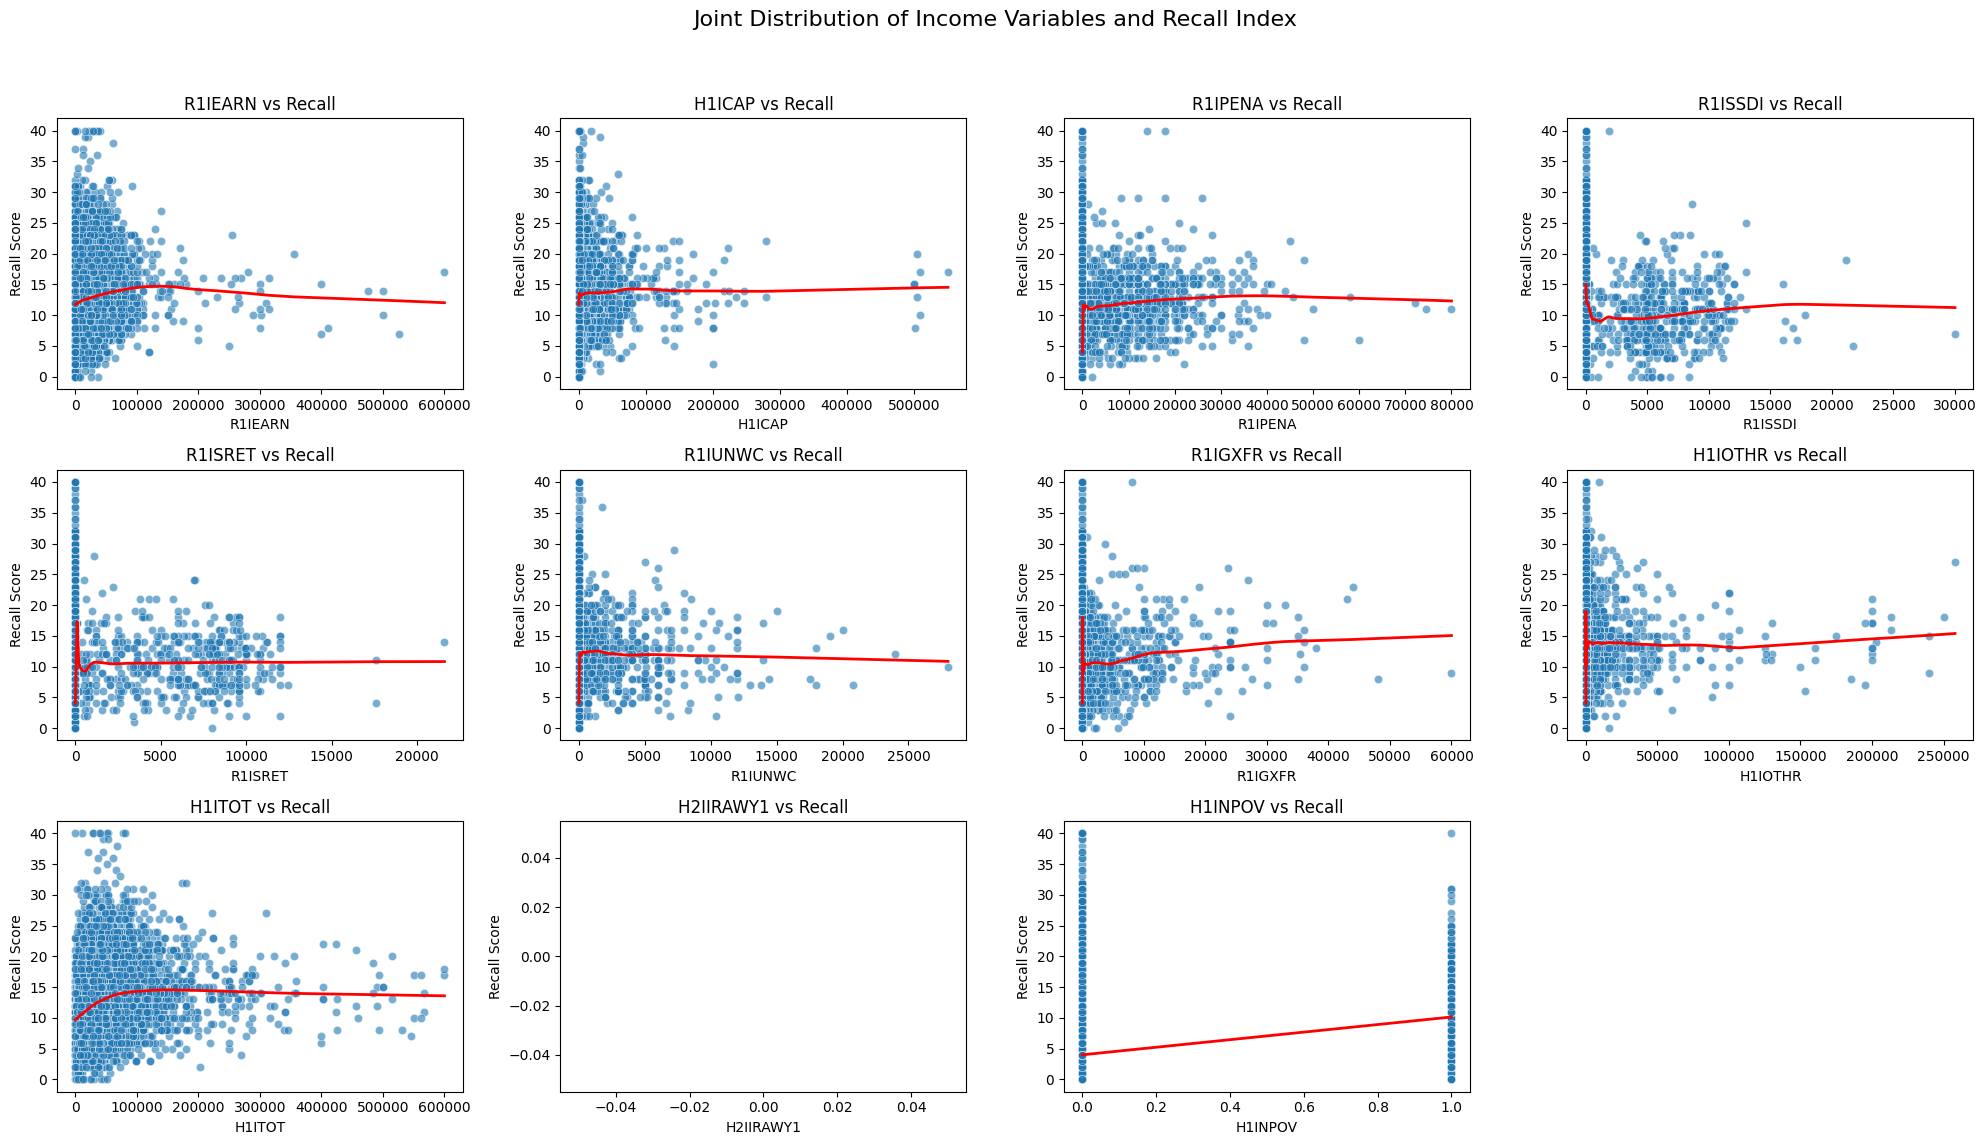

C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=binned, y=data_set[outcomeVars[0]], palette="Set2", ax=ax)
C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=binned, y=data_set[outcomeVars[0]], palette="Set2", ax=ax)
C:\Users\98422\AppData\Local\Temp\ipykernel_35752\1695133990.py:48: UserWarning: set_ticklabels(

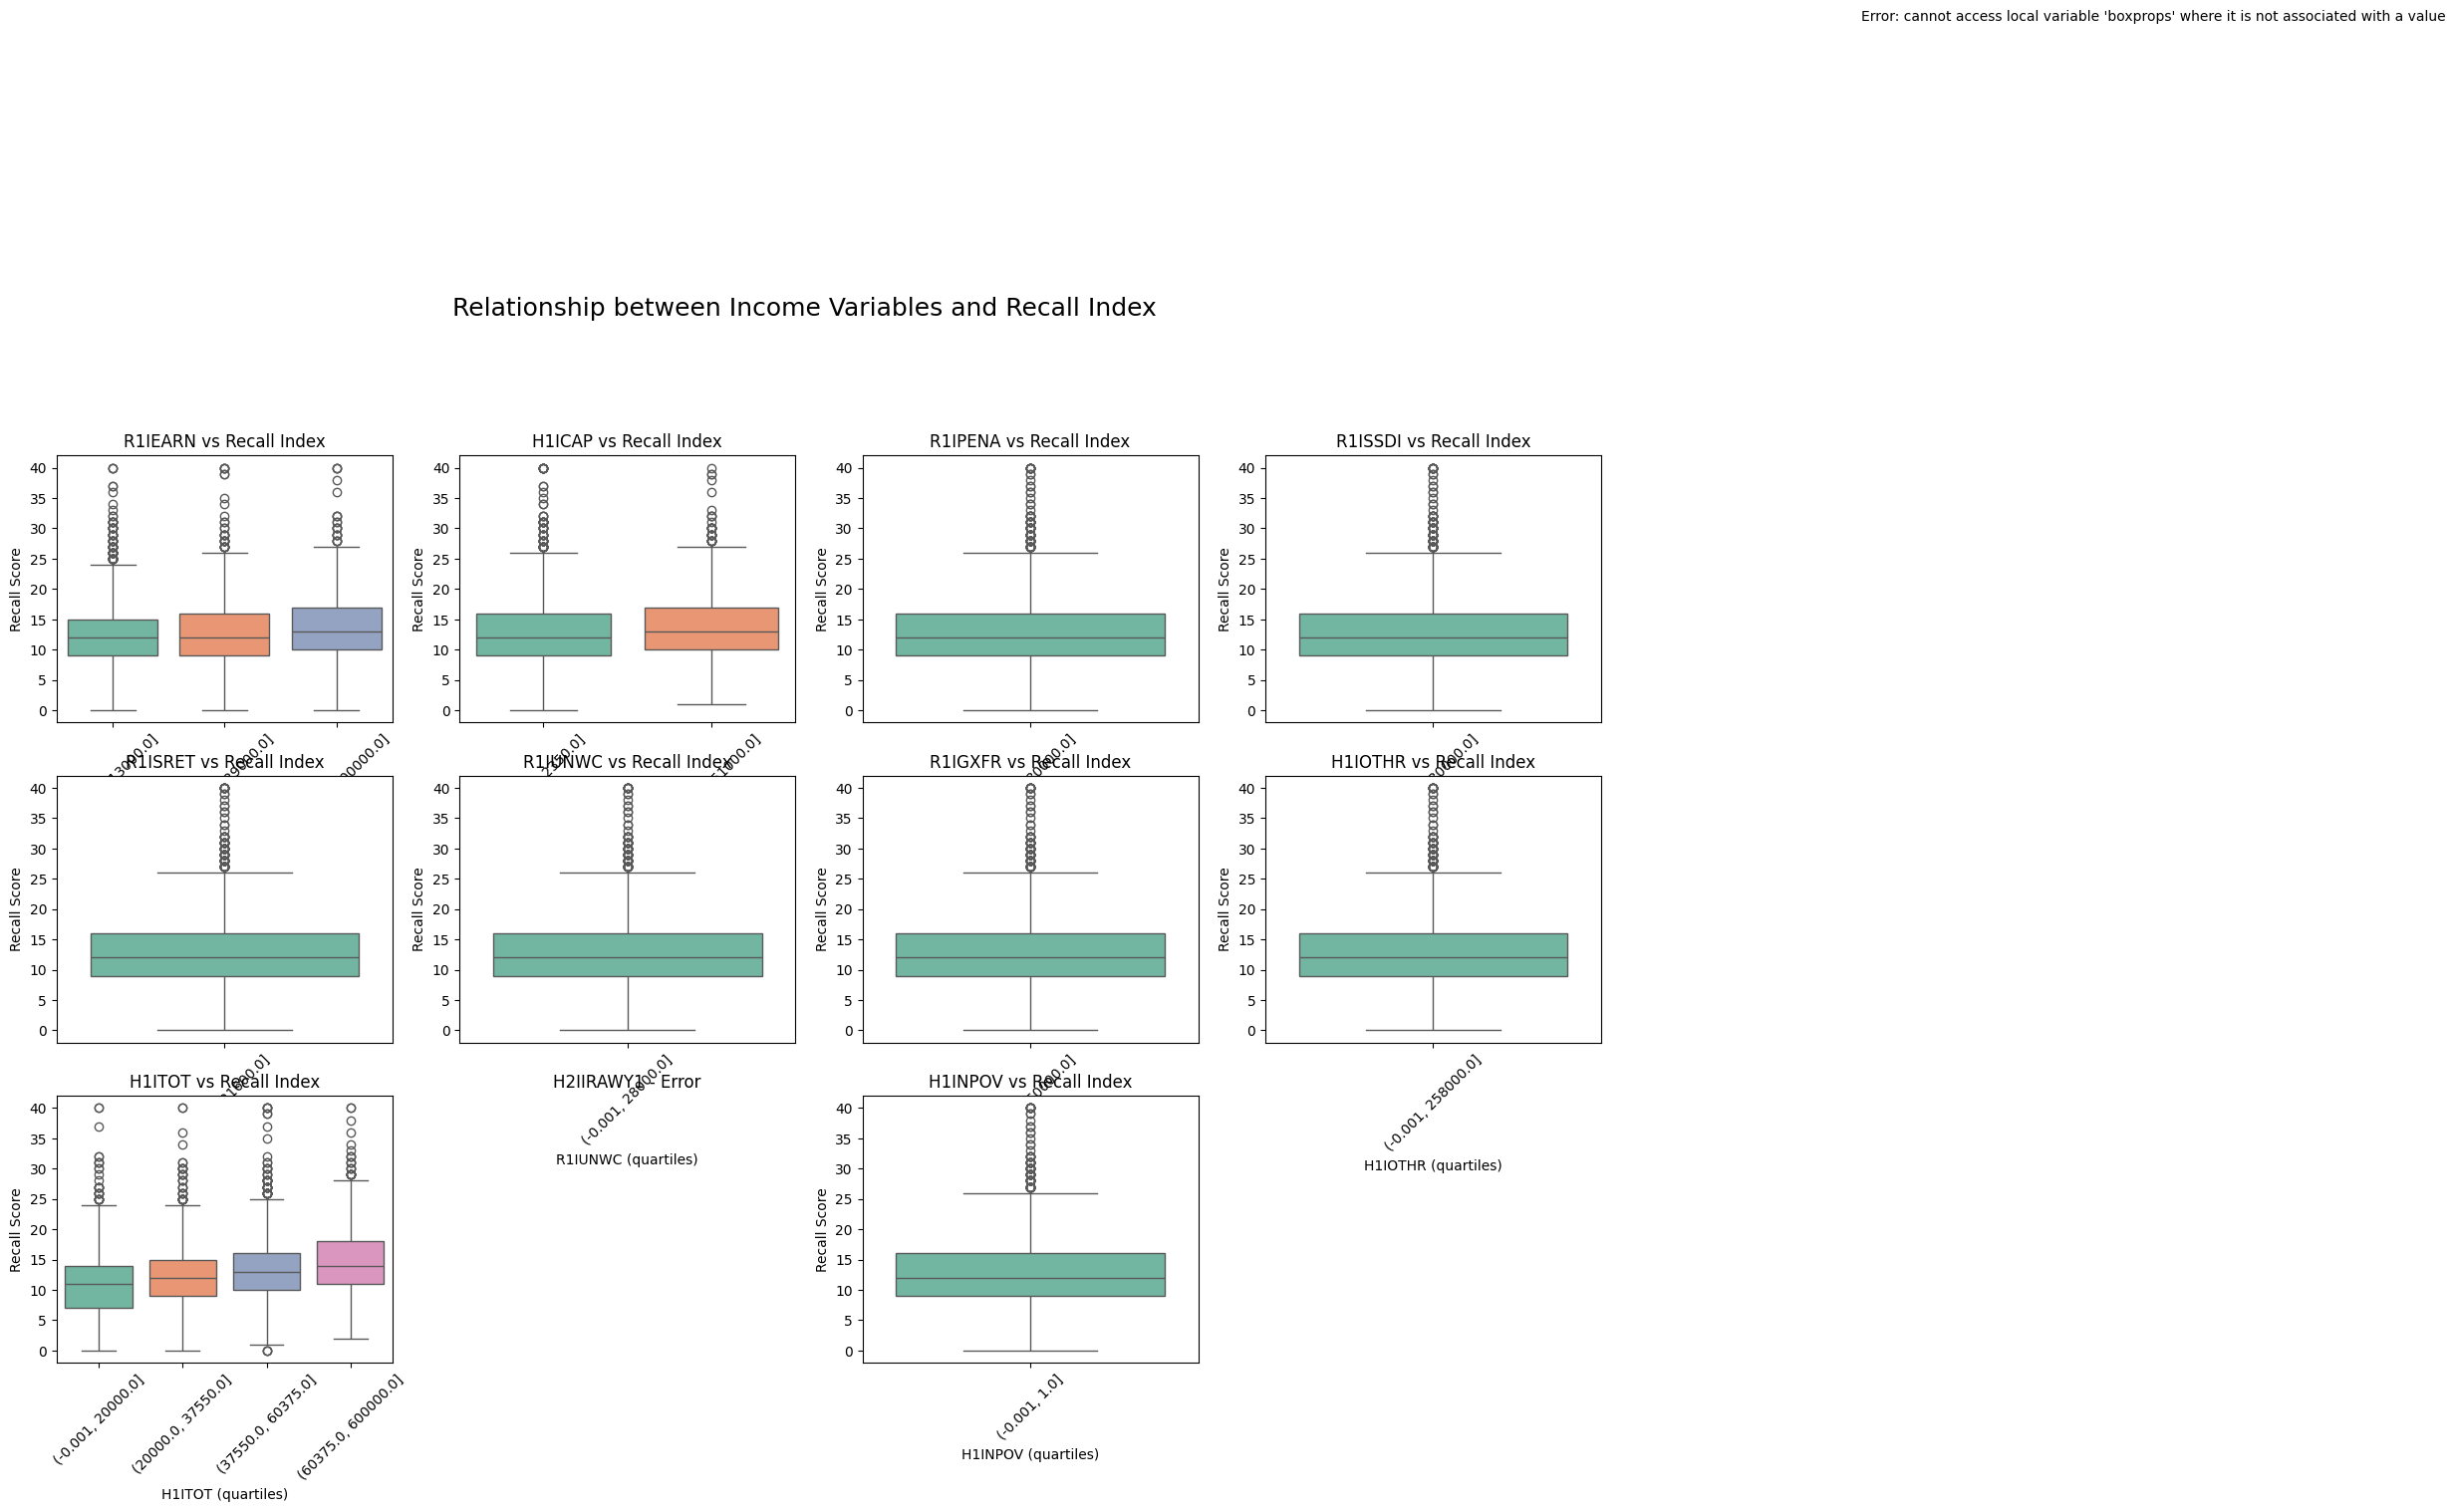

In [29]:
plot_distribution(IncomeVars,waveOneIncome,'Income')
plot_relationship(IncomeVars,waveOneIncome,'Income')

## 3.4 Function limitations Variables & BMI
1. BMI
RwBMI: weight divided by the square of height. Beginning in Wave 3, height is only asked of new Respondents, but weight is asked in every wave.

2. Disabilities & Function limitations
RwHLTHLM: whether an impairment or healthproblemlimits the kindor amount of paidwork for theRespondent. p854 [categorical variable]
REBEDRID:  whether the Respondent was bedridden in the last three months of life. p858 [catgeorical variable]
RwWALKR: Diff-Walk across room. p878,905 [catgeorical variable]
RwWALKRH: Gets Help Walk across room. p880 [catgeorical variable]
RwDRESS: Diff-Dressing. p883 [catgeorical variable]
RwDRESSH: GetsHelp-Dressing. p885 [catgeorical variable]
RwBATH: Diff-Bathing or showering. p887 [catgeorical variable]
RwBATHH: Gets Help-Bathing,showering. p889 [catgeorical variable]
RwEAT: Diff-Eating. p891 [catgeorical variable]
RwEATH: GetsHelp-Eating. p893 [catgeorical variable]
RwBED: Diff-Get in/out of bed. p895 [catgeorical variable]
RwBEDH: Gets Help-Get in/out of bed. p897 [catgeorical variable]
RwTOILT: Diff-Using the toilet. p900 [catgeorical variable]
RwTOILTH: Gets Help-Using the toilet. p902 [catgeorical variable]
In Wave 1, the HRS imputations are left in place. In all other waves "don’t know" is recoded to special missing code .D and "refused" is recoded to .R. In Wave 1, difficulty with an ADL is rated on a 4-point scale from "no difficulty" to "very difficult/can’t do." These are assigned without change. A "don’t do" answer is recoded to "7." (Wave 2 and wave 3 forward is different, please check again when we eda for further eave) p905

RwMAP: Diff-Use a map. p950 [catgeorical variable]
RwPHONE: Diff-Use telephone(no data for wave 1 but good for wave 2 to 16) p954 [catgeorical variable]
RwMONEY: Diff-Managing money(no data for wave 1 but good for wave 2 to 16) p958 [catgeorical variable]
RwMEDS: Diff-Take medications(no data for wave 1 but good for wave 2 to 16) p961 [catgeorical variable]
RwSHOP: Diff-Shop for groceries(no data for wave 1,2 but good for wave 3 to 16) p964 [catgeorical variable]
RwMEALS: Diff-Preparing hot meals(no data for wave 1,2 but good for wave 3 to 16) p967 [catgeorical variable]

3. Depressive symptons
RwCESD: a mental health index, using a score on the Center for Epidemiologic Studies Depression (CESD) scale. The higher the score, the more negative the Respondent’s feelings in the past week. P354 [catgeorical variable]

### Since Many Function Limitation Variables has no data in wave 1 & 2, so in this seesion, we do EDA on wave 3 datset.

In [14]:
waveThree = hrsFull.filter(regex = "^(RA|R3)[a-zA-Z]+", axis = 1)
print(waveThree.shape)
print(waveThree.columns.to_list()[0:50])
waveThree = pd.concat([hrsFull["HHIDPN"], waveThree], axis=1)
waveThree = waveThree[hrsFull["INW3"] == 1] ## Only keep the participants who responded in the first wave
print(waveThree.head())
print(waveThree.shape)

outcomeVars = [
    "R3TR20" # W3 TOTAL WORD RECALL SUMMARY SCORE P775
]
functionlimitationsVars = [
    "R3HLTHLM", 
    "REBEDRID",
    "R3WALKR", 
    "R3WALKRH", 
    "R3DRESS", 
    "R3DRESSH", 
    "R3BATH", 
    "R3BATHH", 
    "R3EAT", 
    "R3EATH",
    "R3BED", 
    "R3BEDH", 
    "R3TOILT", 
    "R3TOILTH",
    "R3CESD",
    "R3BMI",
    "R3MAP", 
    "R3PHONE", 
    "R3MONEY", 
    "R3MEDS", 
    "R3SHOP",
    "R3MEALS"
]

WaveThreeFunctionLimitations = hrsFull.loc[hrsFull["INW3"] == 1, ["HHIDPN"] + outcomeVars + functionlimitationsVars]

print(WaveThreeFunctionLimitations.head())
print(WaveThreeFunctionLimitations.shape)
print(WaveThreeFunctionLimitations.info())
print(WaveThreeFunctionLimitations.isna().any(axis=1).sum())

(10000, 714)
['R3MSTAT', 'R3MPART', 'RASPID1', 'RASPID2', 'RASPID3', 'RASPID4', 'RASPCT', 'R3MRCT', 'R3MLEN', 'R3MCURLN', 'R3MLENM', 'R3MDIV', 'R3MWID', 'R3MNEV', 'R3MEND', 'R3MSTATH', 'R3MSTATF', 'R3CENREG', 'R3CENDIV', 'RAOAHDID', 'RAOHRSID', 'RAOVRLAP', 'RAGENDER', 'RAHISPAN', 'RARACEM', 'RABMONTH', 'RABYEAR', 'RABDATE', 'RABFLAG', 'R3IWBEG', 'R3IWEND', 'R3IWENDF', 'R3IWMID', 'R3IWMIDF', 'R3PROXY', 'R3IWSTAT', 'RADMONTH', 'RADYEAR', 'RADDATE', 'RADSRC', 'RADTIMTDTH', 'RADAGE_M', 'RADAGE_Y', 'RAEDYRS', 'RAEDEGRM', 'RAEDUC', 'RABPLACF', 'R3URBRUR', 'RARELIG', 'RAVETRN']
       HHIDPN  R3MSTAT  R3MPART     RASPID1  RASPID2  RASPID3  RASPID4  \
1      2010.0      7.0      0.0         NaN      NaN      NaN      NaN   
2      3010.0      1.0      0.0      3020.0      NaN      NaN      NaN   
3      3020.0      1.0      0.0      3010.0      NaN      NaN      NaN   
4  10001010.0      8.0      0.0         NaN      NaN      NaN      NaN   
5  10003020.0      1.0      0.0  10003030.0      NaN

D:\python\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
D:\python\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
D:\python\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
D:\python\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
D:\python\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
D:\python\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered

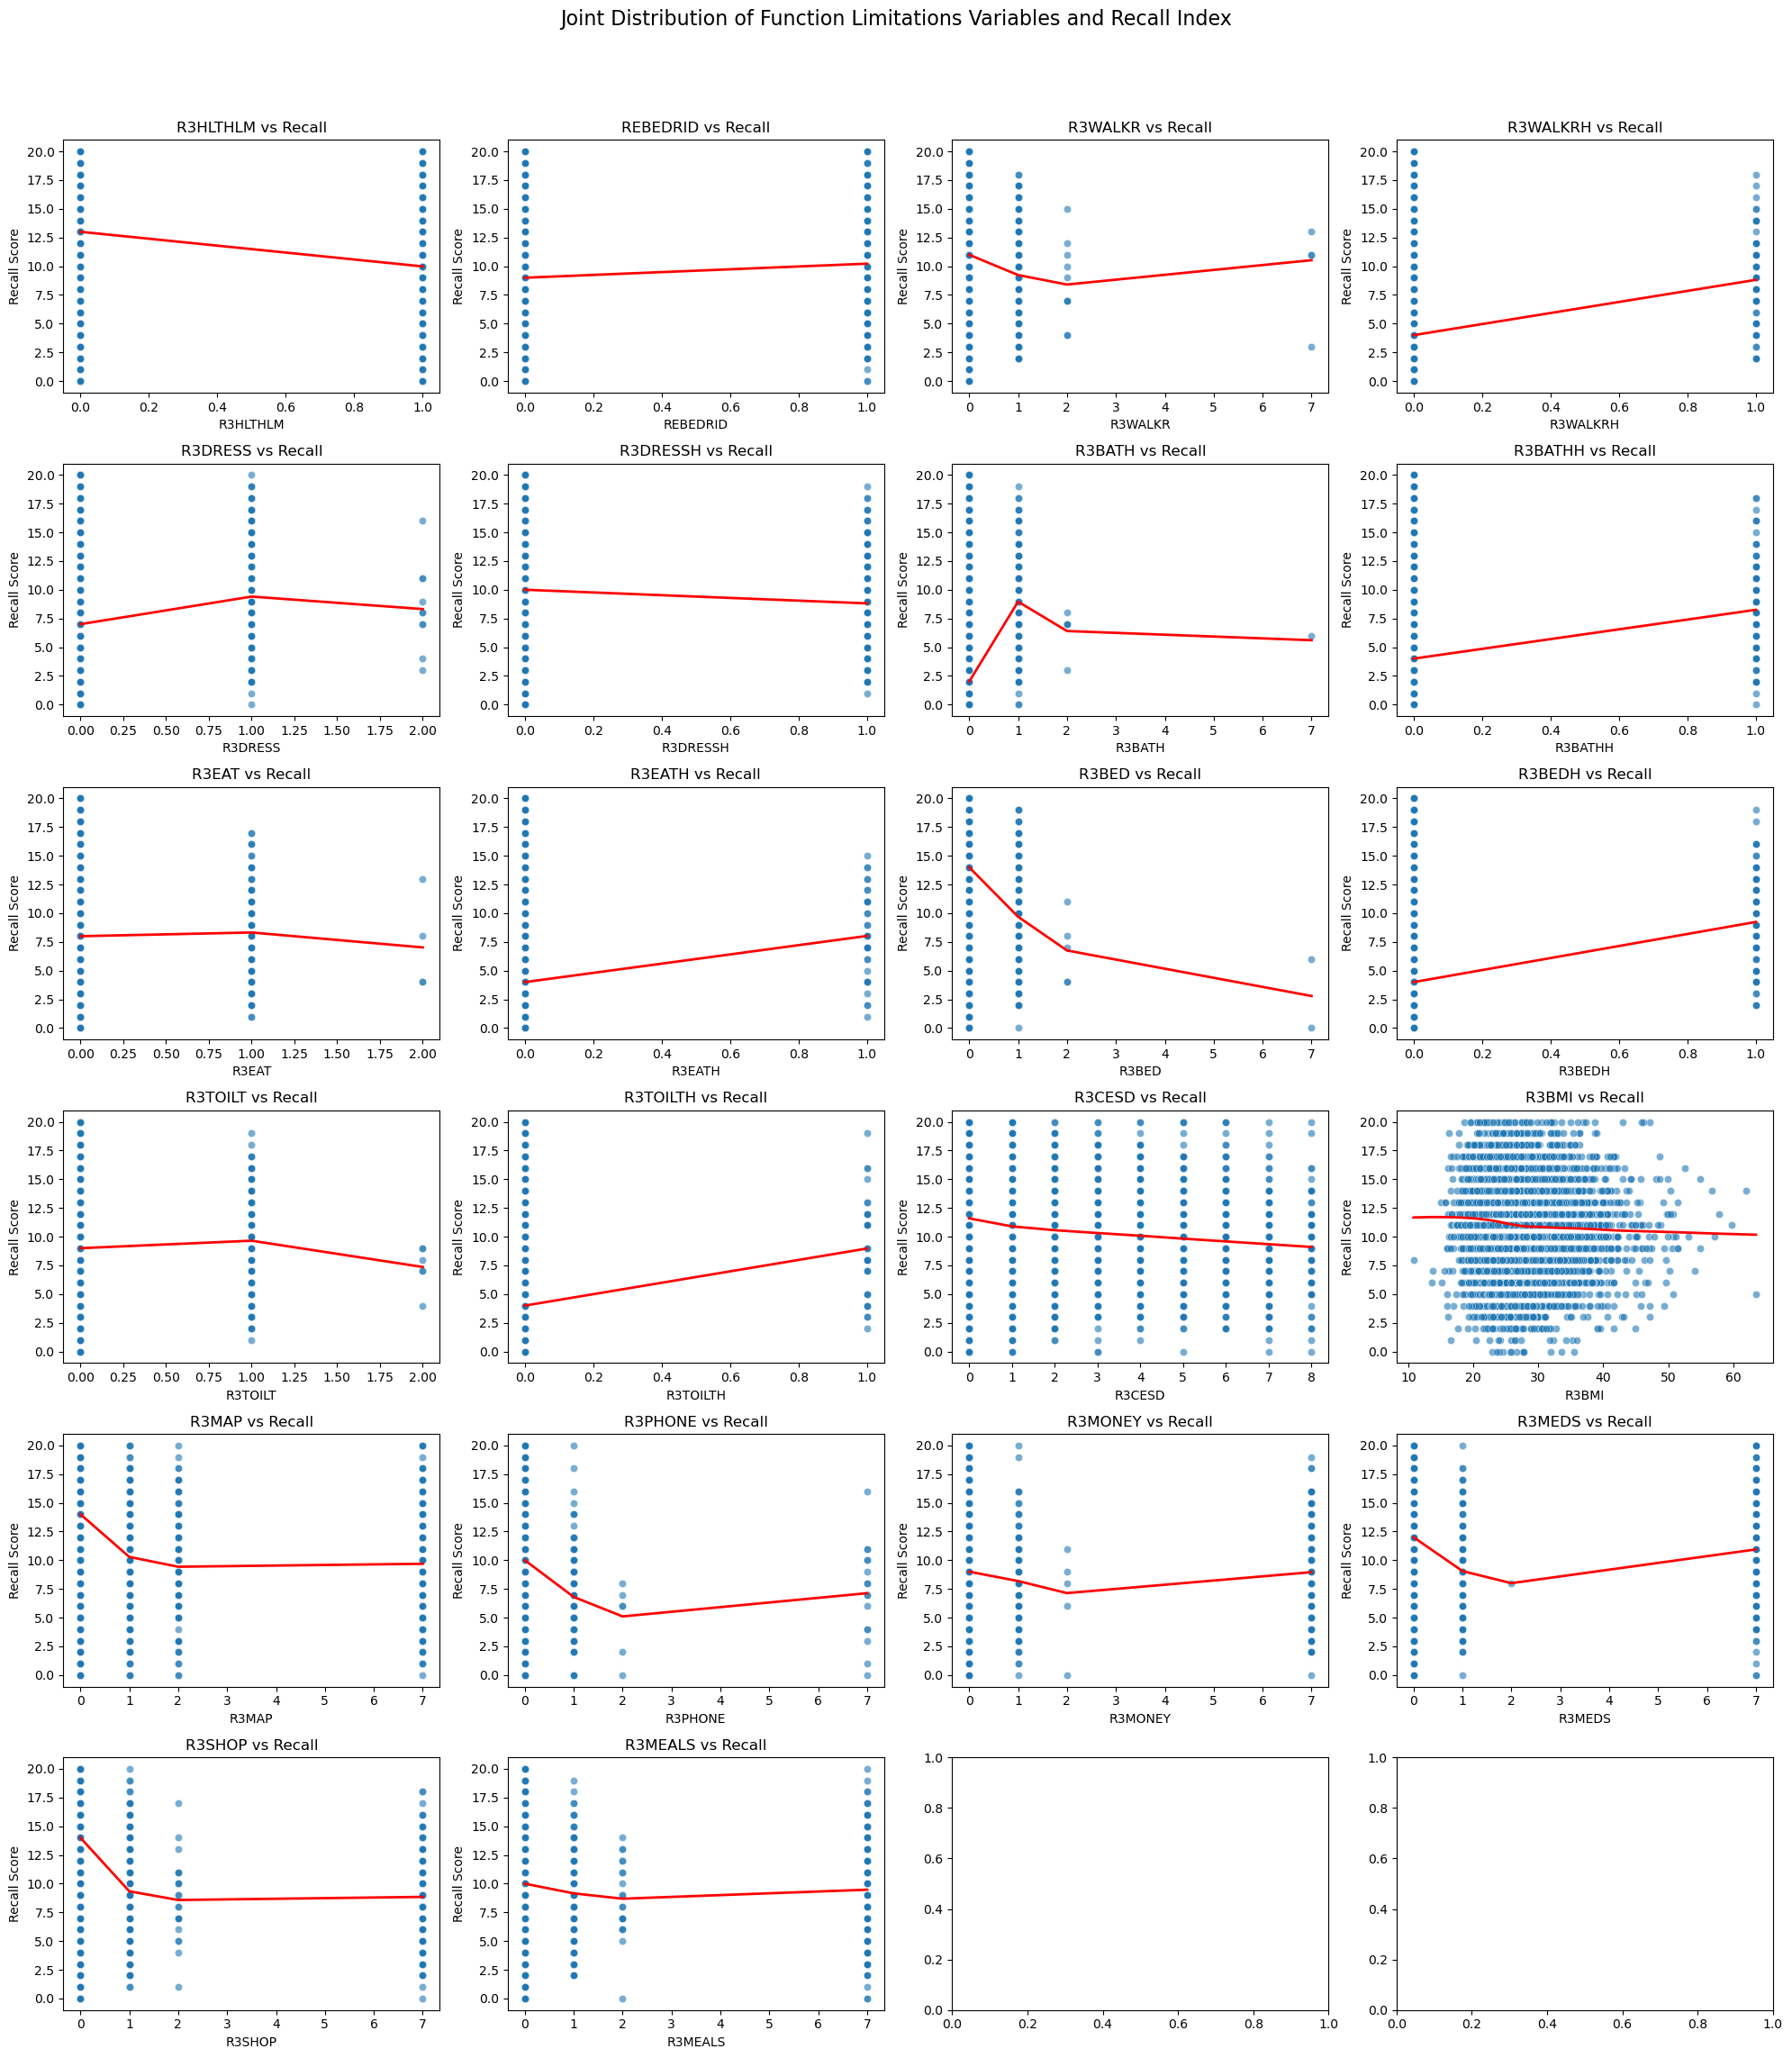

In [18]:
def plot_distribution_all(plot_vars,data_set,plot_vars_name=''):
    n_cols = 4
    n_rows = (len(plot_vars) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle("Joint Distribution of "+ plot_vars_name + " Variables and Recall Index", fontsize=16)

    # 把 axes 展平为一维数组，方便遍历
    axes = axes.flatten()

    for idx, col in enumerate(plot_vars):
        ax = axes[idx]
        sns.scatterplot(
            data=data_set,
            x=col,
            y=outcomeVars[0],
            ax=ax,
            alpha=0.6
        )
        sns.regplot(
            data=data_set,
            x=col,
            y=outcomeVars[0],
            scatter=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 2},
            ax=ax
        )
        ax.set_title(f"{col} vs Recall")
        ax.set_xlabel(col)
        ax.set_ylabel("Recall Score")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_distribution_all(functionlimitationsVars, WaveThreeFunctionLimitations,'Function Limitations')

D:\Temp\ipykernel_22264\1512925044.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_set, x=col, ax=ax, palette="Set2")
D:\Temp\ipykernel_22264\1512925044.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_set, x=col, ax=ax, palette="Set2")
D:\Temp\ipykernel_22264\1512925044.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_set, x=col, ax=ax, palette="Set2")
D:\Temp\ipykernel_22264\1512925044.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

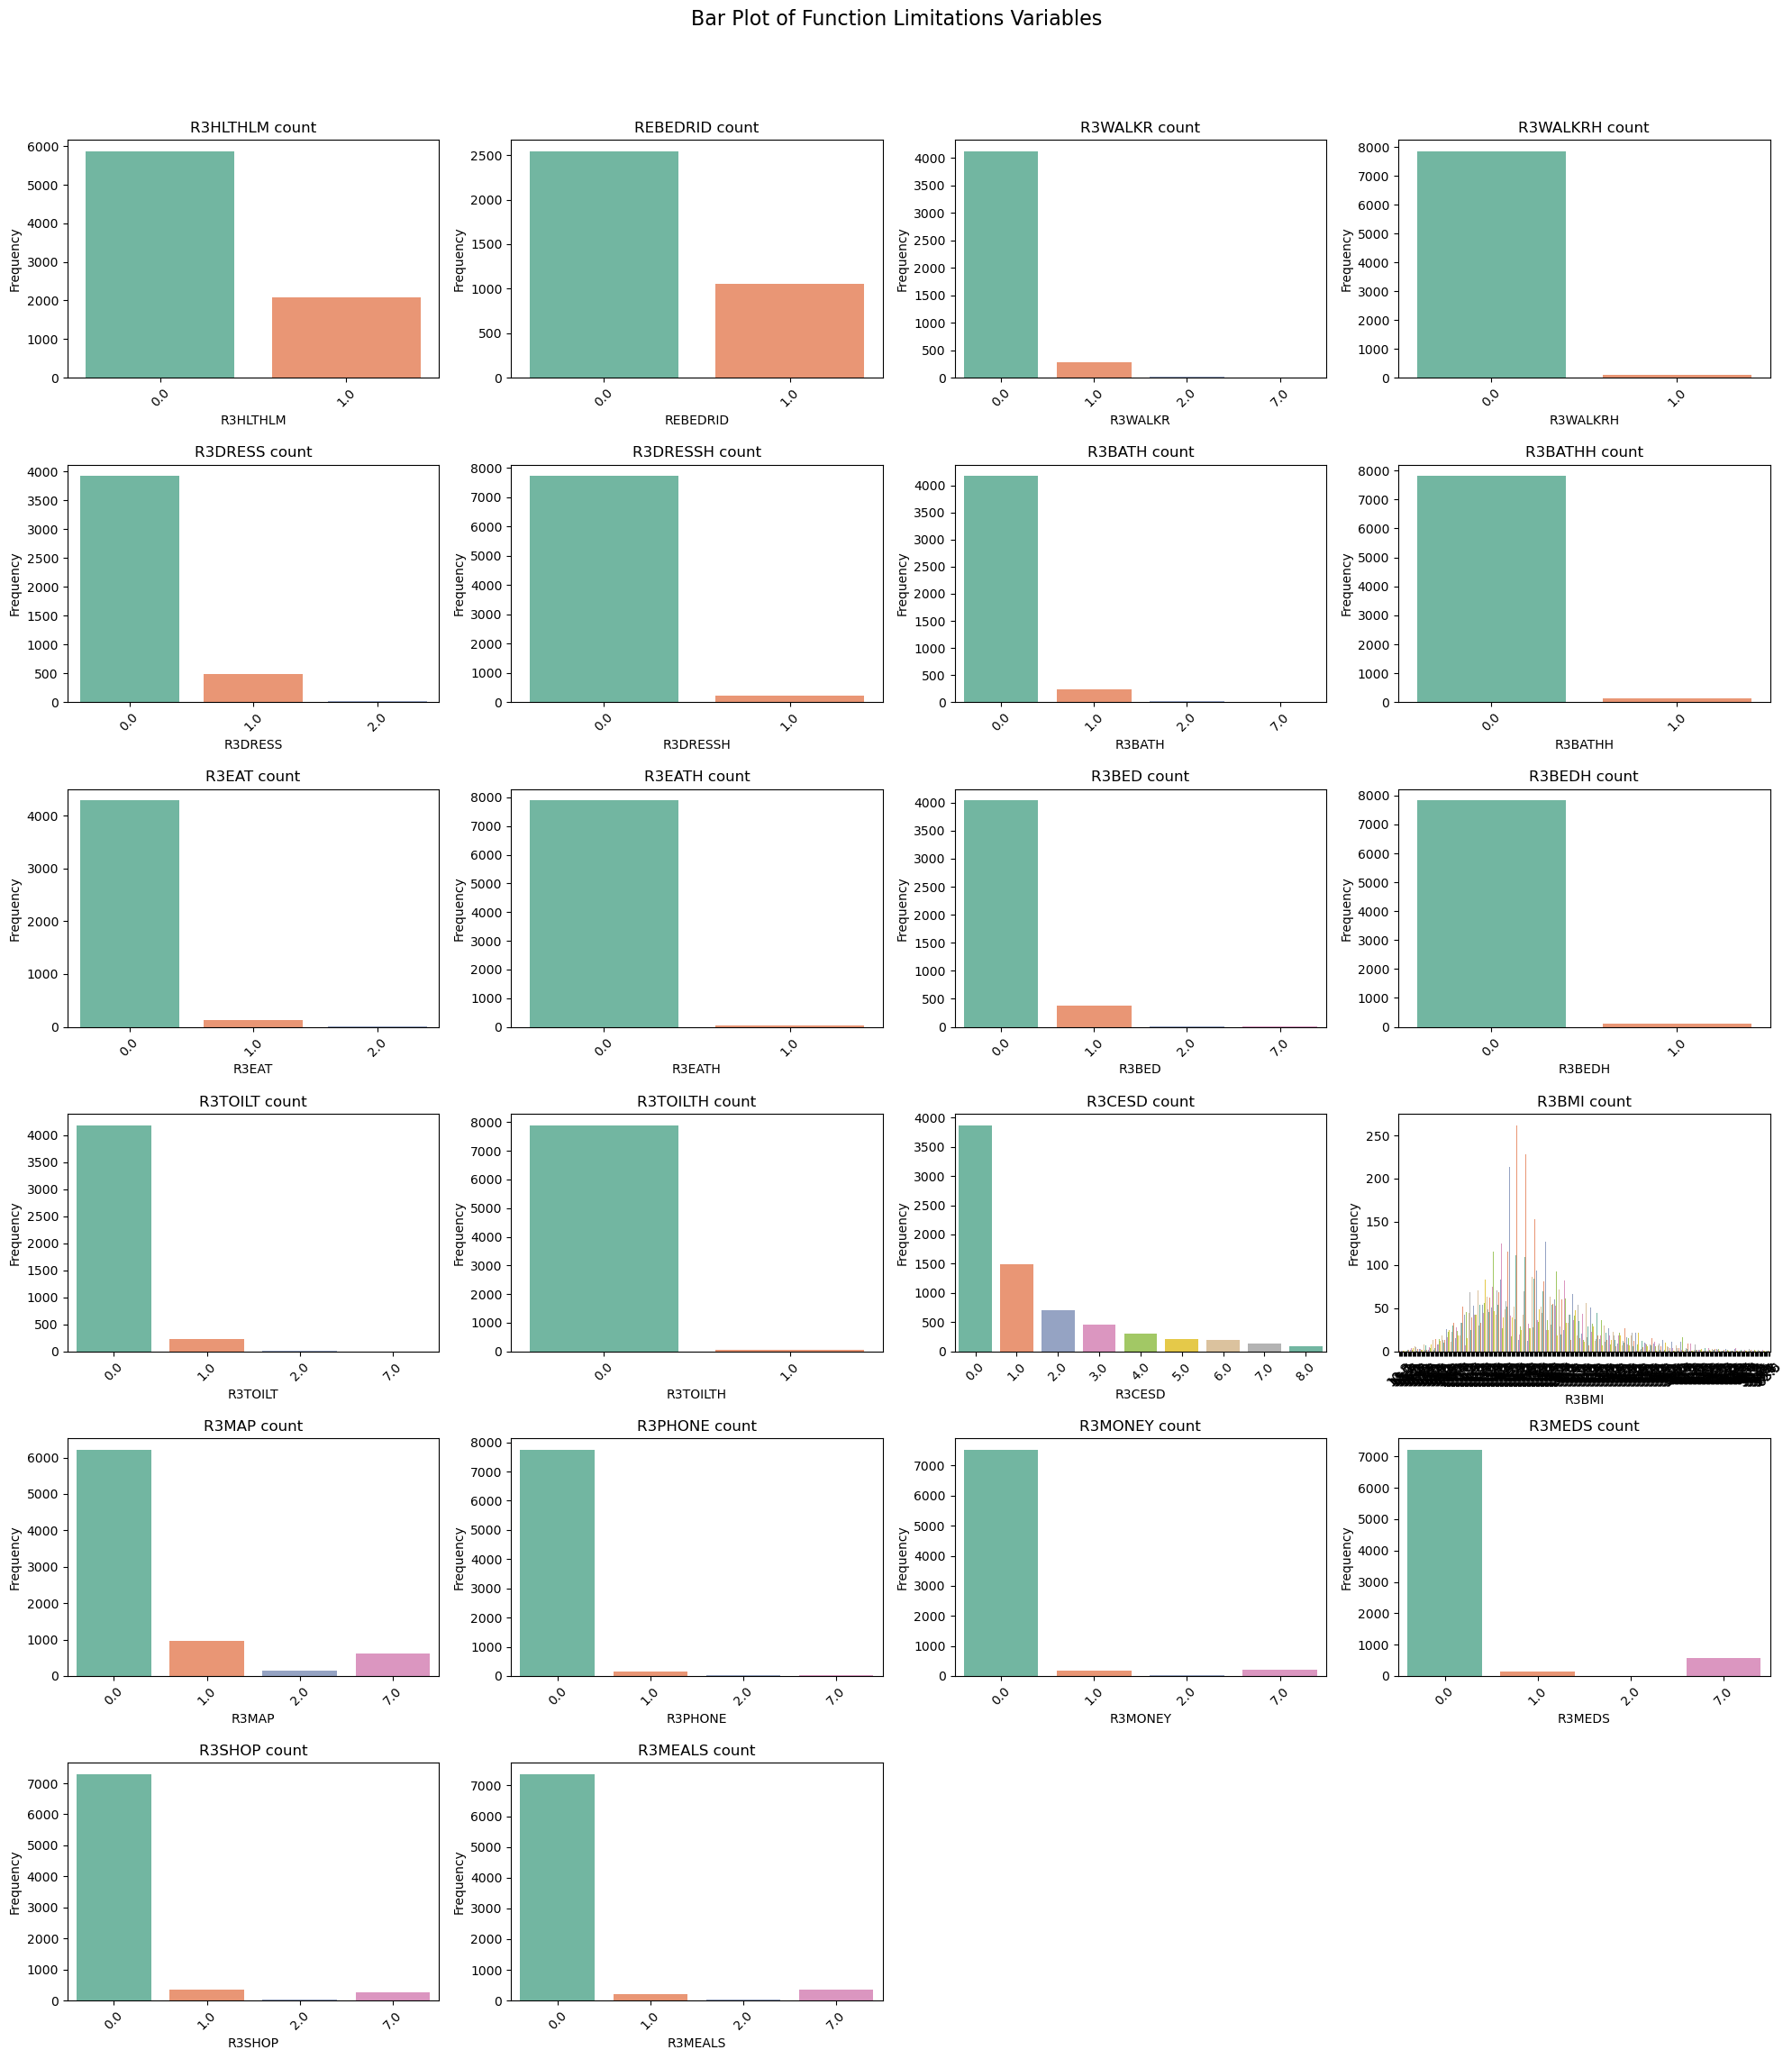

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_charts_all(plot_vars, data_set, plot_vars_name=''):
    n_cols = 4
    n_rows = (len(plot_vars) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle("Bar Plot of " + plot_vars_name + " Variables", fontsize=16)

    # 展平 axes 方便访问
    axes = axes.flatten()

    for idx, col in enumerate(plot_vars):
        ax = axes[idx]
        sns.countplot(data=data_set, x=col, ax=ax, palette="Set2")
        ax.set_title(f"{col} count")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.tick_params(axis='x', rotation=45)

    # 删除多余的 subplot
    for j in range(len(plot_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_bar_charts_all(functionlimitationsVars, WaveThreeFunctionLimitations, 'Function Limitations')

# 5. Simple Regression Analysis

In [ ]:
def ols_fit(var,response_var='R5COG27', data = data):
    filtered_dropna = data.dropna(subset=[var ,response_var])
    X = filtered_dropna[[var]]  # 自变量（分类变量，字符串类型）
    y = filtered_dropna[response_var]    # 因变量（数值型，float）


    # 独热编码（将字符串分类变量转换为数值）
    X_encoded = pd.get_dummies(X, columns=[var], drop_first=True)

    # 强制转换为浮点型（避免布尔类型导致object错误）
    X_encoded = X_encoded.astype(float)

    # 添加截距项
    X_encoded = sm.add_constant(X_encoded, has_constant='add')


    # 拟合线性回归模型
    try:
        model = sm.OLS(y.astype(float), X_encoded.astype(float)).fit()
        print(model.summary())
    except Exception as e:
        print(f"错误信息: {str(e)}")
        print("排查建议:")
        print("1. 检查 X_encoded 是否存在全为常数的列（如所有样本属于同一类别）")
        print("2. 确保 y 中没有缺失值: y.isnull().sum() =", y.isnull().sum())
        print("3. 数据集filter正确", head(filtered_dropna))

In [6]:
# 认知能力 与 职业 的拟合
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data[var]))
ols_fit(var = var, response_var = response_var)

{'14.Operators: machine', '09.Personal svc', '10.Farming/forestry/fishing', '02.Prof specialty opr/tech sup', '17.Member of Armed Forces', '15.Operators: transport, etc', '16.Operators: handlers, etc', '13.Precision production', '11.Mechanics/repair', nan, '07.Svc:food prep', '12.Constr trade/extractors', '05.Svc:prv hhld/clean/bldg svc', '08.Health svc', '06.Svc:protection', '03.Sales', '01.Managerial specialty oper', '04.Clerical/admin supp'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     62.77
Date:                Tue, 20 May 2025   Prob (F-statistic):          8.42e-188
Time:                        10:56:10   Log-Likelihood:                -16909.
No. Observations:                6087   AIC:                         3.385e+0

In [20]:
# 认知能力 与 视力 的拟合
response_var= 'R5COG27'
var = 'R1JSIGHT'

print(set(data[var]))
ols_fit(var = var, response_var = response_var)

{'2.Most of the time', '4.None/almost none of time', '3.Some of the time', '1.All/almost all the time', nan}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.057
Date:                Tue, 20 May 2025   Prob (F-statistic):            0.00169
Time:                        14:00:07   Log-Likelihood:                -17274.
No. Observations:                6054   AIC:                         3.456e+04
Df Residuals:                    6050   BIC:                         3.458e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.97

In [22]:
# 认知能力 与 职业压力 的拟合
response_var= 'R5COG27'
var = 'R1JSTRES'

print(set(data[var]))
ols_fit(var = var, response_var = response_var)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     13.81
Date:                Tue, 20 May 2025   Prob (F-statistic):           5.63e-09
Time:                        14:07:26   Log-Likelihood:                -17228.
No. Observations:                6043   AIC:                         3.446e+04
Df Residuals:                    6039   BIC:                         3.449e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
# 认知能力 与 职业 的拟合 condition on 视力 = ['4.None/almost none of time', '3.Some of the time']
response_var= 'R5COG27'
var = 'R1JCOCC'

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSIGHT'].isin(['4.None/almost none of time', '3.Some of the time'])  # 请根据实际数据调整具体值
]

ols_fit(var = var, response_var = response_var,data = tem_data)

                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     11.87
Date:                Tue, 20 May 2025   Prob (F-statistic):           3.83e-26
Time:                        13:50:51   Log-Likelihood:                -1894.9
No. Observations:                 673   AIC:                             3822.
Df Residuals:                     657   BIC:                             3894.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [ ]:
# 认知能力 与 职业 的拟合 condition on 视力 = ['1.All/almost all the time', '2.Most of the time']
response_var= 'R5COG27'
var = 'R1JCOCC'

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSIGHT'].isin(['1.All/almost all the time'])  # 请根据实际数据调整具体值
]

ols_fit(var = var, response_var = response_var,data = tem_data)

                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     35.65
Date:                Tue, 20 May 2025   Prob (F-statistic):          7.72e-102
Time:                        13:57:10   Log-Likelihood:                -9068.8
No. Observations:                3274   AIC:                         1.817e+04
Df Residuals:                    3257   BIC:                         1.828e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [24]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['4.Strongly disagree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['4.Strongly disagree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3.296
Date:                Tue, 20 May 2025   Prob (F-statistic):           4.83e-05
Time:                        14:09:14   Log-Likelihood:                -764.68
No. Observations:                 266   AIC:                             1561.
Df Residuals:                     250   BIC:                             1619.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

c:\Users\98422\miniconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [ ]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['2.Agree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['2.Agree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     24.96
Date:                Tue, 20 May 2025   Prob (F-statistic):           2.72e-69
Time:                        14:10:59   Log-Likelihood:                -7111.2
No. Observations:                2565   AIC:                         1.426e+04
Df Residuals:                    2548   BIC:                         1.436e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [29]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['1.Strongly agree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['1.Strongly agree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     10.82
Date:                Tue, 20 May 2025   Prob (F-statistic):           2.61e-26
Time:                        14:12:22   Log-Likelihood:                -3285.5
No. Observations:                1192   AIC:                             6605.
Df Residuals:                    1175   BIC:                             6691.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [ ]:
# 认知能力 与 职业 的拟合 condition on 职业压力 = ['1.Strongly agree', '2.Agree']
response_var= 'R5COG27'
var = 'R1JCOCC'

print(set(data['R1JSTRES']))

filtered_dropna = data.dropna(subset=['R5COG27','R1JSTRES','R1JCOCC'])
tem_data = filtered_dropna.loc[
    filtered_dropna['R1JSTRES'].isin(['1.Strongly agree', '2.Agree'])  # 请根据实际数据调整具体值
]



ols_fit(var = var, response_var = response_var,data = tem_data)

{'4.Strongly disagree', '3.Disagree', '2.Agree', nan, '1.Strongly agree'}
                            OLS Regression Results                            
Dep. Variable:                R5COG27   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     35.56
Date:                Tue, 20 May 2025   Prob (F-statistic):          1.11e-102
Time:                        14:12:56   Log-Likelihood:                -10409.
No. Observations:                3757   AIC:                         2.085e+04
Df Residuals:                    3740   BIC:                         2.096e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------